# PC Boxes and Variables Automatization

## Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy as sp
import os
from itertools import combinations

import sys
import seaborn as sns
import re
import pickle


import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [3]:

from IndexDrivers import (
    MultivariatePCA, 
    plot_hw_index,
    plot_hw_index_by_season,
    scatter_color_year,
    scatter_color_season
)

In [4]:
def df_to_series(dataframe, name_series, years=[1979,2023]):
    selected = dataframe[(dataframe["Year"]< years[1]) & (dataframe["Year"] > years[0])]
    df_melted = selected.melt(id_vars=['Year'], var_name='Month', value_name=name_series)
    df_melted["Month"] = pd.to_numeric(df_melted["Month"])
    df_melted = df_melted.sort_values(['Year','Month'])

    df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
    df_melted.set_index('Date', inplace=True)

    return df_melted.drop(columns=["Year", "Month"])

def plot_corr(dataframe, cols):
    sns.heatmap(dataframe.corr()[cols], cmap="coolwarm", annot=True)
    plt.show()

def compute_correlations(df, num_indices=5, method='pearson'):
    """
    Compute the correlation between the first `num_indices` columns and the rest of the columns in a DataFrame
    using the specified method (Pearson, Spearman, or Kendall).
    
    Parameters:
    - df: pd.DataFrame, the input DataFrame with timeseries as columns.
    - num_indices: int, number of columns to use as the principal indices for correlation.
    - method: str, the method for correlation ('pearson', 'spearman', 'kendall').
    
    Returns:
    - pd.DataFrame with correlations between the `num_indices` columns and the rest of the columns.
    """
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Method must be 'pearson', 'spearman', or 'kendall'")

    # Extract the first `num_indices` columns as principal indices
    principal_df = df.iloc[:, :num_indices]
    
    # Extract the rest of the columns
    other_df = df.iloc[:, num_indices:]
    
    # If method is not 'pearson', we need to use rank correlation methods
    if method == 'spearman':
        # Rank the data for Spearman correlation
        principal_df = principal_df.rank()
        other_df = other_df.rank()
    elif method == 'kendall':
        # Pandas `.corr()` will be used for Kendall to handle pairwise calculation
        return other_df.corrwith(principal_df, axis=0, method='kendall')
    
    # Compute correlation matrix using dot product for Pearson or Spearman
    principal_values = principal_df.values
    other_values = other_df.values
    
    # Mean-center the data
    principal_mean_centered = principal_values - principal_values.mean(axis=0)
    other_mean_centered = other_values - other_values.mean(axis=0)
    
    # Compute the standard deviations
    principal_std = principal_values.std(axis=0)
    other_std = other_values.std(axis=0)
    
    # Normalize data
    principal_normalized = principal_mean_centered / principal_std
    other_normalized = other_mean_centered / other_std
    
    # Compute the correlation matrix using dot product
    correlations = np.dot(other_normalized.T, principal_normalized) / (other_values.shape[0] - 1)
    
    # Convert to DataFrame for readability, using original column names
    correlation_df = pd.DataFrame(
        correlations,
        columns=df.columns[:num_indices],  # Names of the principal indices columns
        index=df.columns[num_indices:]     # Names of the remaining columns
    )
    
    return correlation_df


In [5]:
ds_5means = xr.load_dataset("data/local_data/5means_world.nc")
generate_pcas = False

## Define Automatization

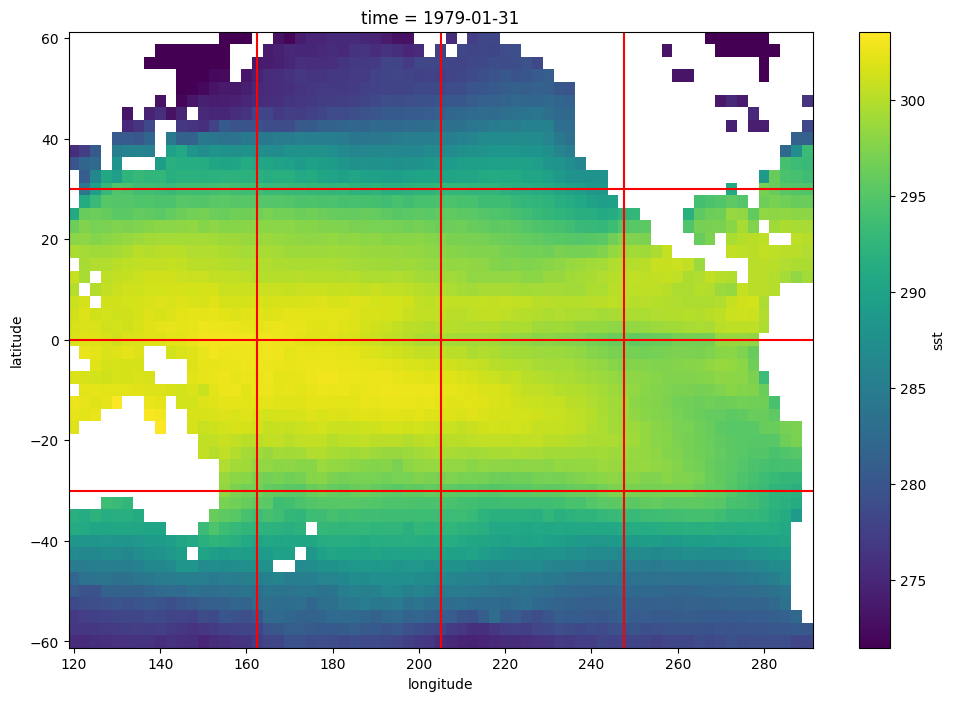

In [6]:
boxes1 = {
    0: [120,205,30,60],
    1: [205,290,30,60],
    2: [120,205,0,30],
    3: [205,290,0,30],
    4: [120,205,-30,0],
    5: [205,290,-30,0],
    6: [120,205,-60,-30],
    7: [205,290,-60,-30]
}
# New dictionary to hold 16 sub-boxes
boxes2 = {}

# Counter for keys in boxes2
new_key = 0

# Iteratively split each box into two
for key, (lon_min, lon_max, lat_min, lat_max) in boxes1.items():
    # Calculate the longitude midpoint
    lon_mid = (lon_min + lon_max) / 2
    
    # Define two new sub-boxes by splitting along the longitude midpoint
    boxes2[new_key] = [lon_min, lon_mid, lat_min, lat_max]
    new_key += 1
    boxes2[new_key] = [lon_mid, lon_max, lat_min, lat_max]
    new_key += 1

fig, axs = plt.subplots(figsize=(12,8))
ds_5means.sel(latitude=slice(-60,60), longitude=slice(120,290)).sst.isel(time=0).plot(ax=axs)
for i in range(3):
    axs.axhline(-30+i*30, c="red")
axs.axvline(205, c="red")
axs.axvline(162.5, c="red")
axs.axvline(247.5, c="red")
plt.show()

In [7]:
if generate_pcas:
    variables = ["SST", "SP", "TTR", "U10", "V10"]
    var_combi = []

    for r in range(1, len(variables) + 1):
        var_combi.extend(combinations(variables, r))

    # Iterate over each box and each combination of variables
    k = 0
    pcas = {}
    for box_id, box_coords in boxes2.items():
        for var_combination in var_combi:
            pcas[k] = MultivariatePCA(ds_5means, 3, [1980,2022], box_limit=box_coords, variables=var_combination)

            k +=1

    for box_id, box_coords in boxes1.items():
        for var_combination in var_combi:
            pcas[k] = MultivariatePCA(ds_5means, 3, [1980,2022], box_limit=box_coords, variables=var_combination)

            k +=1
else:
    with open("pcas.pkl", 'rb') as inp:
        pcas = pickle.load(inp)

In [9]:
hwis_chile= pd.read_csv(f"data/local_data/monthly/HWs_chile_central.csv")
hwis_chile["Date"] = pd.to_datetime(hwis_chile["Date"],format='%Y-%m-%d')
hwis_chile.set_index('Date', inplace=True)
hwis_chile = hwis_chile.rolling(2).mean()
hwis_cali= pd.read_csv(f"data/local_data/monthly/HWs_california.csv")
hwis_cali["Date"] = pd.to_datetime(hwis_cali["Date"],format='%Y-%m-%d')
hwis_cali.set_index('Date', inplace=True)
hwis_cali = hwis_cali.rolling(2).mean()


In [10]:
hwis_chile = hwis_chile[hwis_chile.index.year >= 1989]
hwis_chile.describe()

HWN         HWF         HWD         HWM         HWA
count  420.000000  420.000000  420.000000  420.000000  420.000000
mean     0.314762    1.200952    0.972143    0.513131    0.938404
std      0.275224    1.180176    0.842713    0.451077    0.831494
min      0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.100000    0.350000    0.300000    0.132811    0.240585
50%      0.250000    0.825000    0.800000    0.413754    0.767462
75%      0.450000    1.700000    1.400000    0.800140    1.492878
max      1.400000    6.600000    4.350000    2.331538    4.114864

In [11]:
hwis_cali.describe()

HWN         HWF         HWD         HWM         HWA
count  419.000000  419.000000  419.000000  419.000000  419.000000
mean     0.500716    2.288544    1.816945    0.834565    1.462751
std      0.427633    2.314116    1.630246    0.699298    1.250629
min      0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.150000    0.600000    0.550000    0.245712    0.429423
50%      0.400000    1.550000    1.400000    0.704787    1.182153
75%      0.750000    3.275000    2.625000    1.290048    2.282397
max      2.400000   13.100000    8.300000    3.188731    5.925198

## Chile

In [12]:
first_year = 1995
hwis_chile = hwis_chile[(hwis_chile.index.year <= 2022) & (hwis_chile.index.year >= first_year)]

for mode in range(pcas[0].n_modes):
    for num, pca in pcas.items():
        hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)

AttributeError: 'MultivariatePCA' object has no attribute 'freq'

In [12]:
corr_chile = hwis_chile.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:]
corr_chile.describe()

HWN          HWF          HWD          HWM          HWA
count  2232.000000  2232.000000  2232.000000  2232.000000  2232.000000
mean      0.006498     0.007595     0.005460     0.007149     0.007118
std       0.088491     0.090611     0.090129     0.088956     0.091074
min      -0.384132    -0.388099    -0.394296    -0.342410    -0.361065
25%      -0.052146    -0.054669    -0.058118    -0.055574    -0.056572
50%       0.009473     0.011733     0.007842     0.009991     0.010174
75%       0.063710     0.068602     0.065911     0.067194     0.068515
max       0.357125     0.366546     0.390240     0.318179     0.341159

In [13]:
indices_of_interest = ["HWN", "HWF", "HWD", "HWM", "HWA"]

season_correlations_chile = {}
seasons_any_corr_chile = {}

for i in range(12):
    hwis_month = hwis_chile[hwis_chile.index.month == i+1]
    correlations = {
    "pearson": compute_correlations(hwis_month),
    "spearman": compute_correlations(hwis_month, method='spearman')
    }

    # Initialize dictionaries to hold positive and negative correlations
    strong_correlations = {
        "positive": {"pearson": [], "spearman": []},
        "negative": {"pearson": [], "spearman": []}
    }
    any_correlations = {
        "positive": {"pearson": [], "spearman": []},
        "negative": {"pearson": [], "spearman": []}
    }

    # Iterate over each correlation matrix and collect pairs
    for method, corr_df in correlations.items():
        for timeserie, row in corr_df.iterrows():
            for index, value in row.items():
                if value > 0.5:
                    strong_correlations["positive"][method].append((timeserie, index, value))
                elif value < -0.5:
                    strong_correlations["negative"][method].append((timeserie, index, value))
                if value > 0:
                    any_correlations["positive"][method].append((timeserie, index, value))
                elif value < 0:
                    any_correlations["negative"][method].append((timeserie, index, value))

    # Convert to DataFrames for easy viewing and saving
    positive_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["positive"].items()
    }
    negative_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["negative"].items()
    }
    positive_corr_any_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in any_correlations["positive"].items()
    }
    negative_corr_any_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in any_correlations["negative"].items()
    }
    season_correlations_chile[i+1] = [positive_corr_df, negative_corr_df]
    seasons_any_corr_chile[i+1] = [positive_corr_any_df, negative_corr_any_df]
    print("Ready season", i+1)



Ready season 1
Ready season 2
Ready season 3
Ready season 4
Ready season 5
Ready season 6
Ready season 7
Ready season 8
Ready season 9
Ready season 10
Ready season 11
Ready season 12


In [14]:
# Initialize a list to collect all correlations from all months and methods
all_correlations = []

# Iterate through each month in the season_correlations_chile dictionary
for month, (positive_corr_dict, negative_corr_dict) in season_correlations_chile.items():
    # Combine positive and negative correlations for each method
    for method in ["pearson", "spearman"]:
        if method in positive_corr_dict:
            for _, row in positive_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))
        
        if method in negative_corr_dict:
            for _, row in negative_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))

# Convert the collected data to a DataFrame for easier processing
all_correlations_df_chile = pd.DataFrame(
    all_correlations, columns=["Season", "Method", "PC", "Index", "Correlation"]
)
all_correlations_df_chile['ID'] = all_correlations_df_chile['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))
# Sort by the absolute value of the correlation and get the top 10

## Include explained variance
all_correlations_df_chile['Variance'] = all_correlations_df_chile.apply(lambda x: pcas[int(x.ID)].explained_variance[str(x.Season)][int(x.PC[-1])-1], axis=1)


top_correlations = all_correlations_df_chile.reindex(
    all_correlations_df_chile["Correlation"].abs().sort_values(ascending=False).index
).head(100)

# Display the top 10 correlations
print(top_correlations)

      Season    Method             PC Index  Correlation   ID  Variance
3700       5  spearman  PC_473-Mode-3   HWD     0.882472  473  0.144623
3699       5  spearman  PC_473-Mode-3   HWF     0.870708  473  0.144623
3698       5  spearman  PC_473-Mode-3   HWN     0.835395  473  0.144623
1674       4   pearson  PC_714-Mode-1   HWD     0.828134  714  0.296015
3007       4  spearman  PC_455-Mode-3   HWA    -0.814642  455  0.092546
...      ...       ...            ...   ...          ...  ...       ...
2112       4   pearson  PC_371-Mode-2   HWD    -0.741177  371  0.214755
3780       5  spearman  PC_472-Mode-1   HWD    -0.739706  472  0.290409
2246       4   pearson  PC_733-Mode-3   HWD    -0.739431  733  0.124292
1672       4   pearson  PC_714-Mode-1   HWN     0.739035  714  0.296015
2510       4  spearman  PC_362-Mode-2   HWF     0.738956  362  0.244144

[100 rows x 7 columns]


In [15]:
# Initialize a list to collect all correlations from all months and methods
any_correlations_list = []

# Iterate through each month in the season_correlations_chile dictionary
for month, (positive_corr_dict, negative_corr_dict) in seasons_any_corr_chile.items():
    # Combine positive and negative correlations for each method
    for method in ["pearson", "spearman"]:
        if method in positive_corr_dict:
            for _, row in positive_corr_dict[method].iterrows():
                any_correlations_list.append((month, method, *row))
        
        if method in negative_corr_dict:
            for _, row in negative_corr_dict[method].iterrows():
                any_correlations_list.append((month, method, *row))

# Convert the collected data to a DataFrame for easier processing
any_correlations_df_chile = pd.DataFrame(
    any_correlations_list, columns=["Season", "Method", "PC", "Index", "Correlation"]
)
any_correlations_df_chile['ID'] = any_correlations_df_chile['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))

In [16]:
top1 = int(list(top_correlations["ID"])[0])
mode_top1 = int(list(top_correlations["PC"])[0][-1])
season_top1 = int(list(top_correlations["Season"])[0])
print(f"Highest correlation is PC_{top1} is on Box {pcas[top1].box} with variables {list(pcas[top1].variables_dict.values())} on mode {mode_top1} for season {season_top1}")

Highest correlation is PC_473 is on Box [247.5, 290, -60, -30] with variables ['SST', 'V10'] on mode 3 for season 5


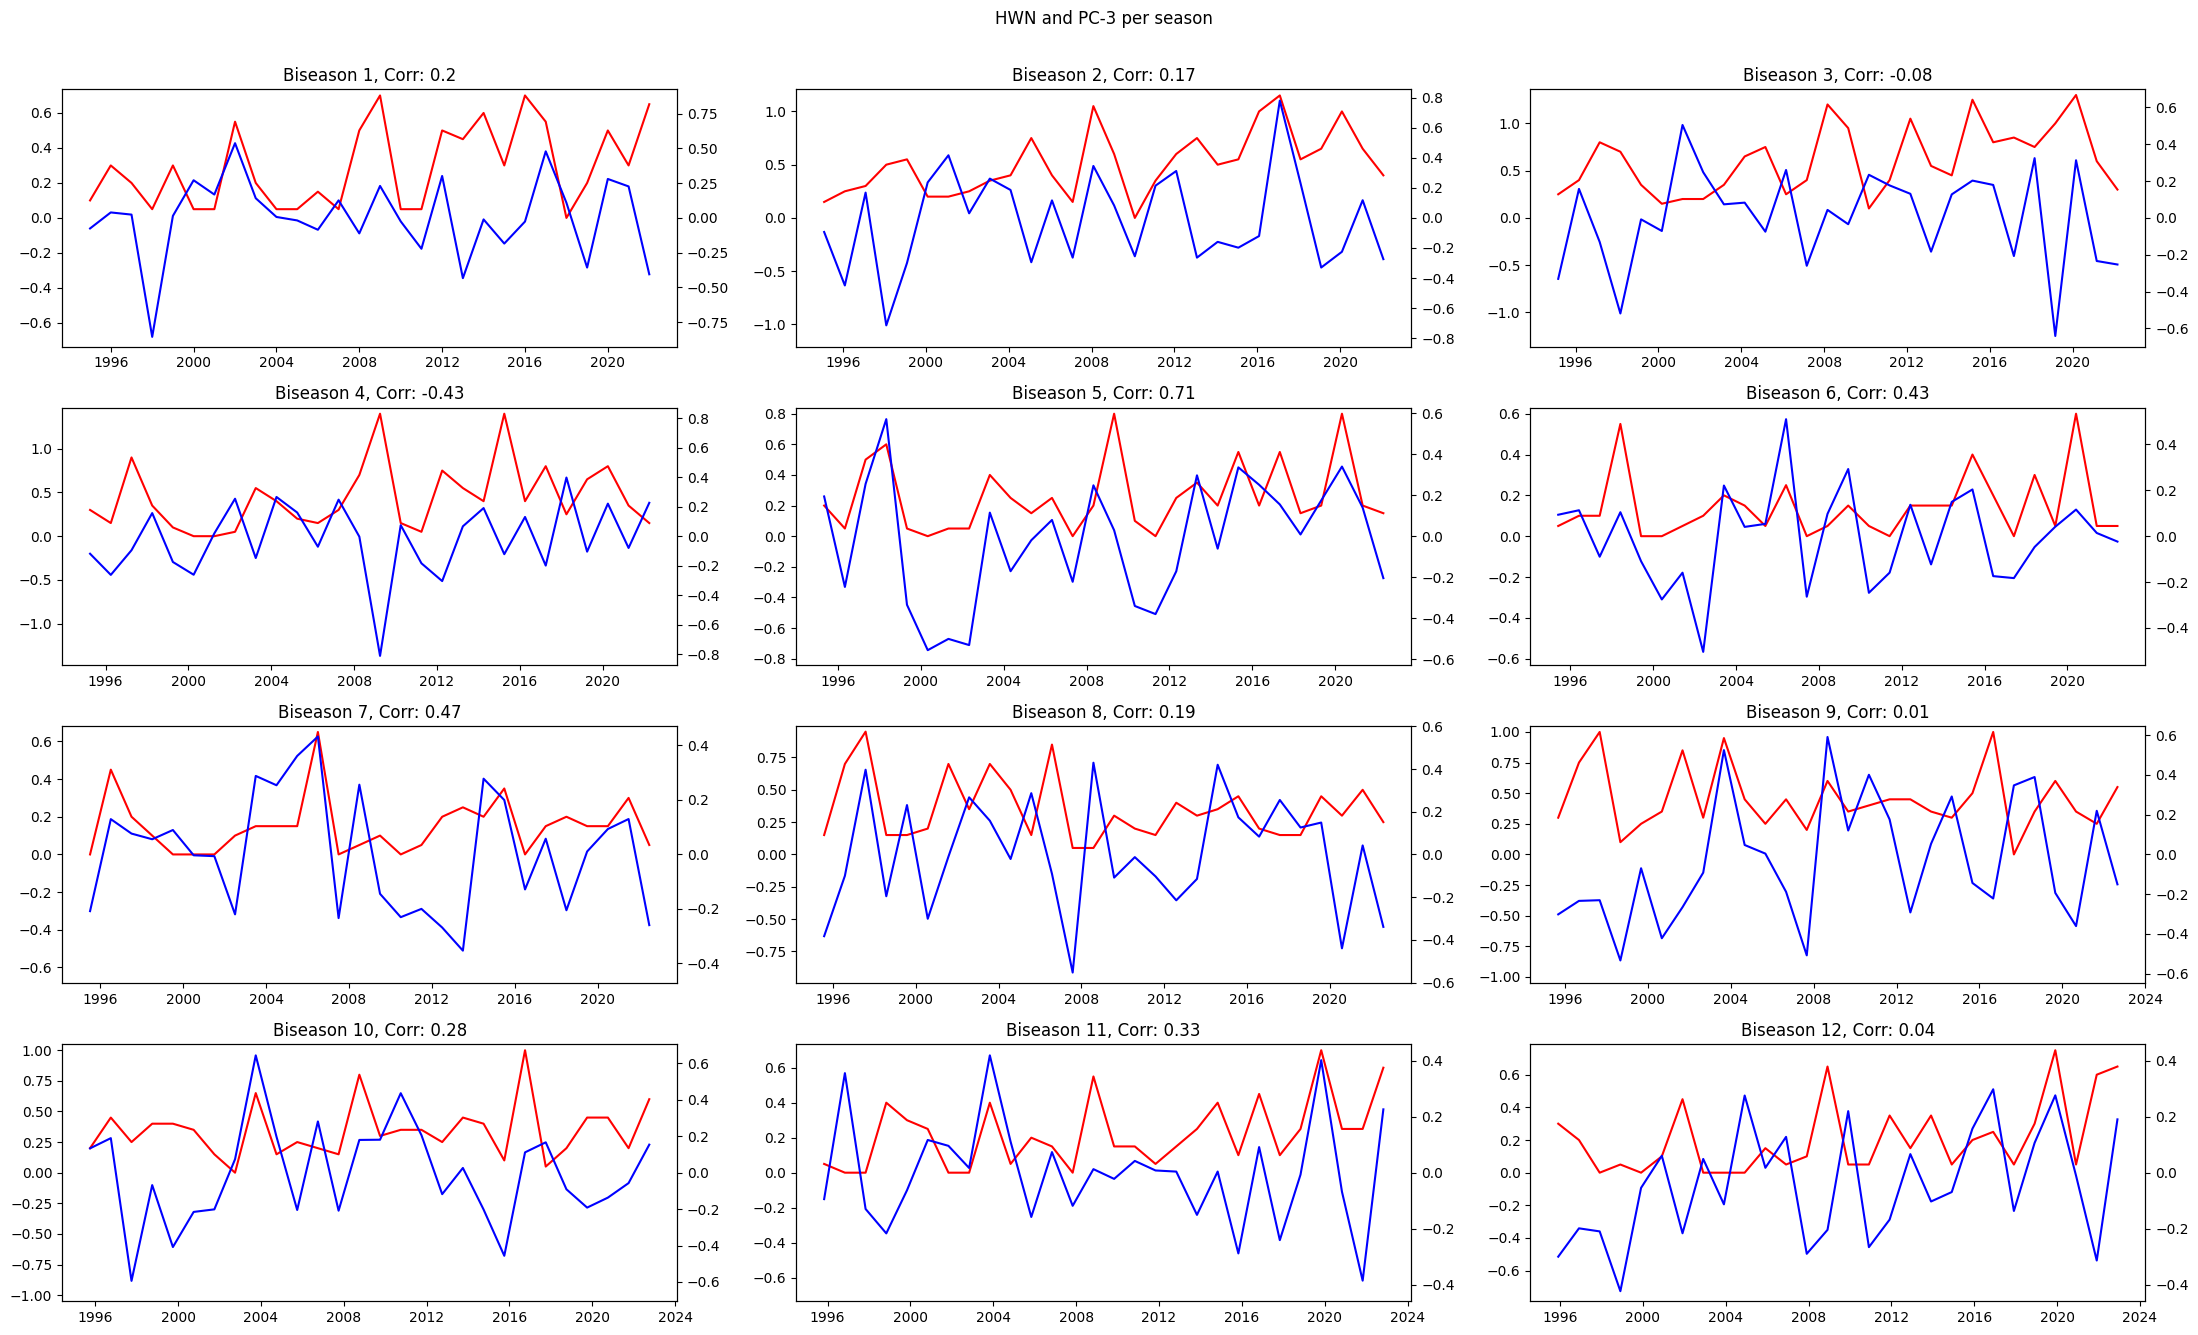

In [17]:
plot_hw_index_by_season(hwis_chile, "HWN", pcas[top1], mode_top1, start=first_year)

### Appearances

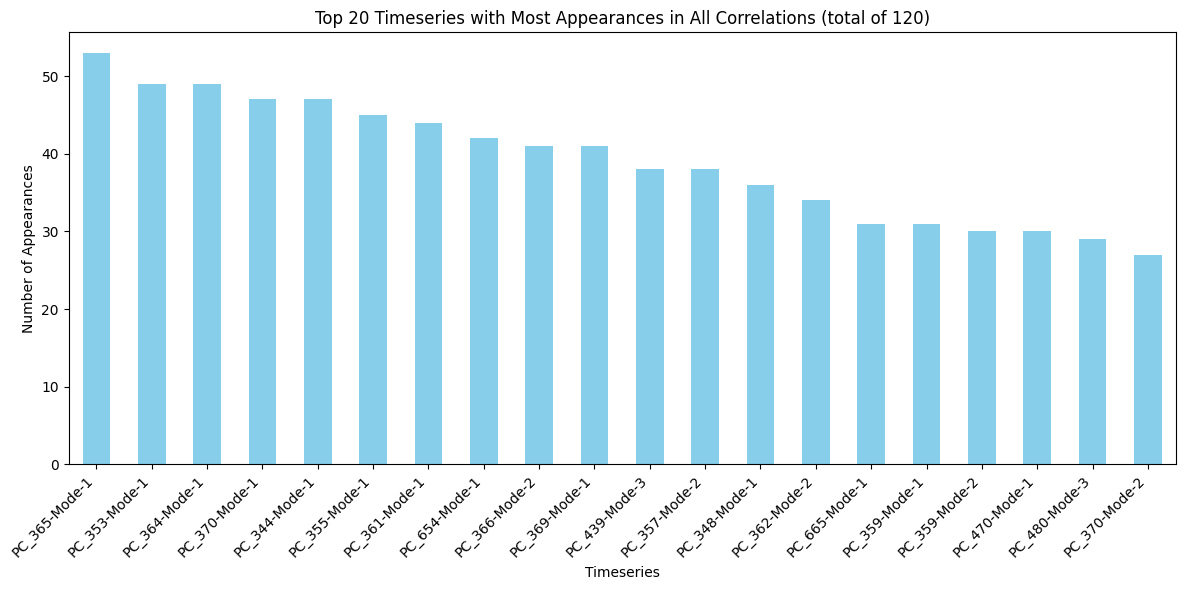

In [18]:
timeseries_count = all_correlations_df_chile['PC'].value_counts()

# Get the top 20 most frequent timeseries
top_20_timeseries = timeseries_count.head(20)

plt.figure(figsize=(12, 6))
top_20_timeseries.plot(kind='bar', color='skyblue')
plt.title('Top 20 Timeseries with Most Appearances in All Correlations (total of 120)')
plt.xlabel('Timeseries')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

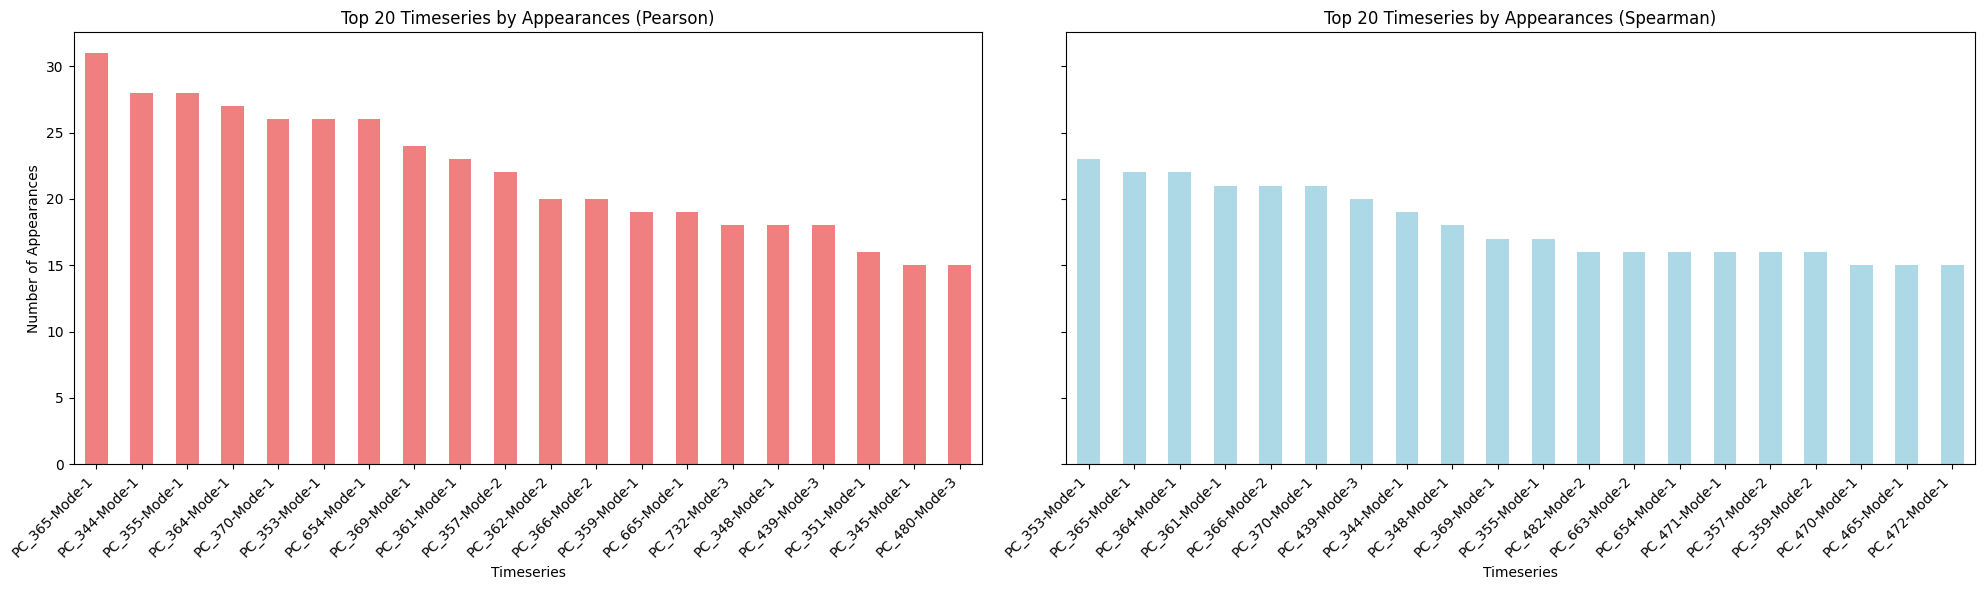

In [19]:
# Filter and count appearances for each method
methods = ["pearson", "spearman"]
method_counts = {}

for method in methods:
    # Filter the DataFrame for the current method
    method_df = all_correlations_df_chile[all_correlations_df_chile['Method'] == method]
    # Count the frequency of each timeseries in the 'Timeserie' column
    method_counts[method] = method_df['PC'].value_counts()

# Get the top 20 timeseries for each method
top_20_counts = {
    method: counts.head(20) for method, counts in method_counts.items()
}

# Plot the top 20 timeseries for each method
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

for i, method in enumerate(methods):
    ax = axes[i]
    top_20_counts[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Appearances ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Number of Appearances')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

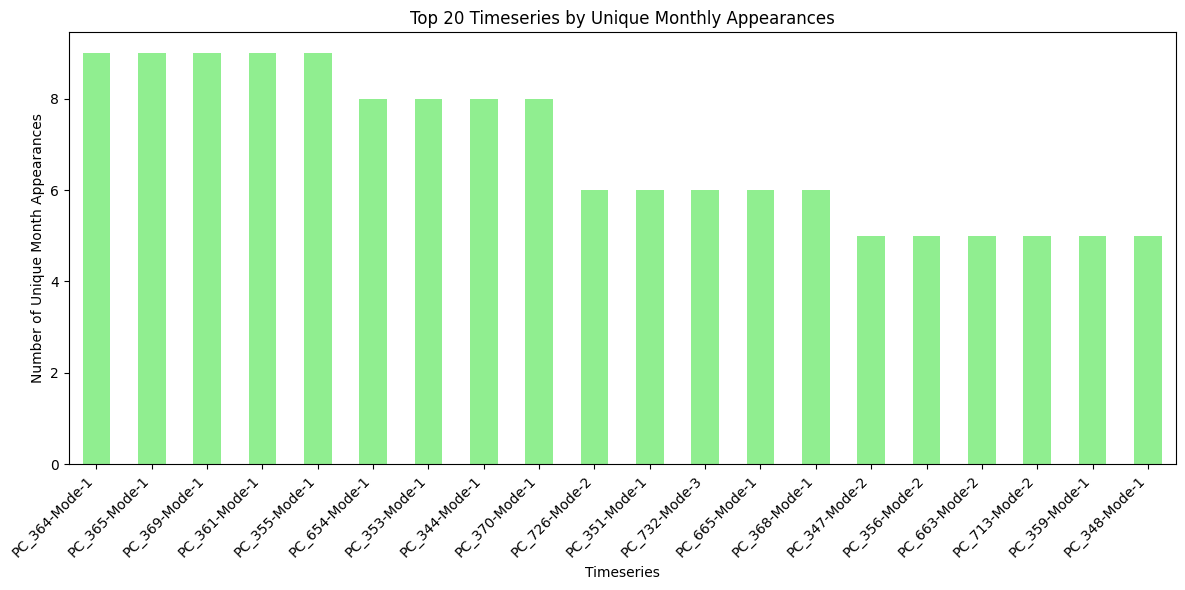

In [20]:
# Create a DataFrame to store unique appearances by month
unique_monthly_counts = all_correlations_df_chile.groupby(['Season', 'PC']).size().reset_index(name='Count')

# Remove duplicate timeseries per month by setting 'Count' to 1 where it exists
unique_monthly_counts['Count'] = 1

# Count how many times each timeseries appears across all months (unique per month)
total_unique_counts = unique_monthly_counts.groupby('PC')['Count'].sum()

# Get the top 20 timeseries by the number of unique month appearances
top_20_unique_timeseries = total_unique_counts.sort_values(ascending=False).head(20)

# Plot the top 20 timeseries in a bar plot
plt.figure(figsize=(12, 6))
top_20_unique_timeseries.plot(kind='bar', color='lightgreen')
plt.title('Top 20 Timeseries by Unique Monthly Appearances')
plt.xlabel('Timeseries')
plt.ylabel('Number of Unique Month Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

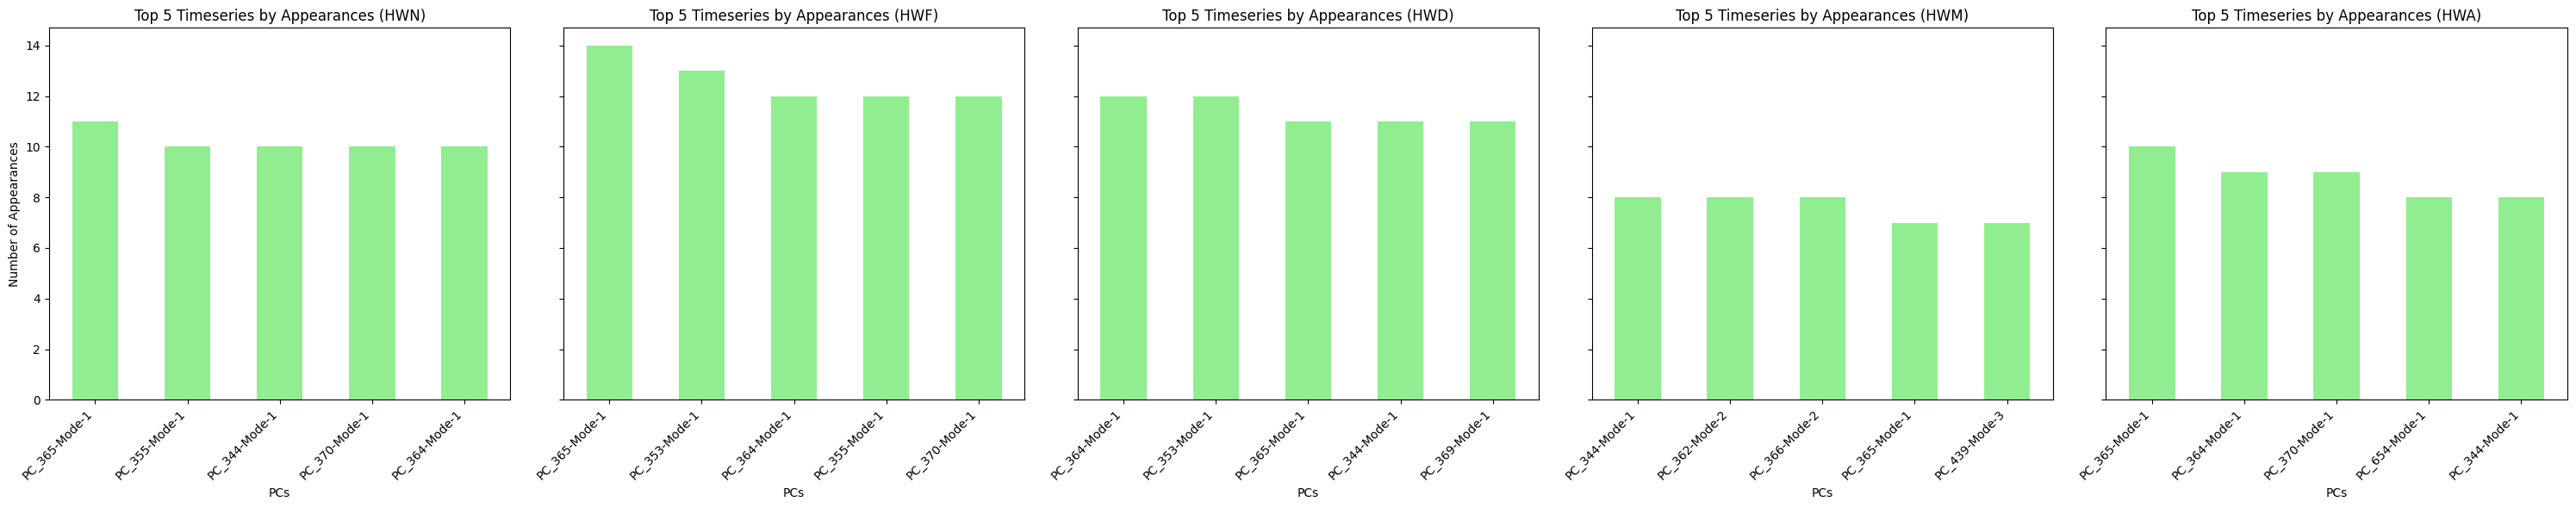

In [21]:
# Initialize a dictionary to store counts for each index
index_counts = {}


# Iterate over each index and count appearances
for index in indices_of_interest:
    # Filter the DataFrame for the current index
    index_df = all_correlations_df_chile[all_correlations_df_chile['Index'] == index]
    # Count the frequency of each timeseries in the 'Timeserie' column
    index_counts[index] = index_df['PC'].value_counts()

# Get the top 20 timeseries for each index
top_20_index_counts = {
    index: counts.head(5) for index, counts in index_counts.items()
}

# Plot the top 20 timeseries for each index
fig, axes = plt.subplots(1, 5, figsize=(30, 6), sharey=True)

for i, index in enumerate(indices_of_interest):
    ax = axes[i]
    if index in top_20_index_counts:
        top_20_index_counts[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Appearances ({index})')
        ax.set_xlabel('PCs')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Number of Appearances')

plt.tight_layout()
plt.show()


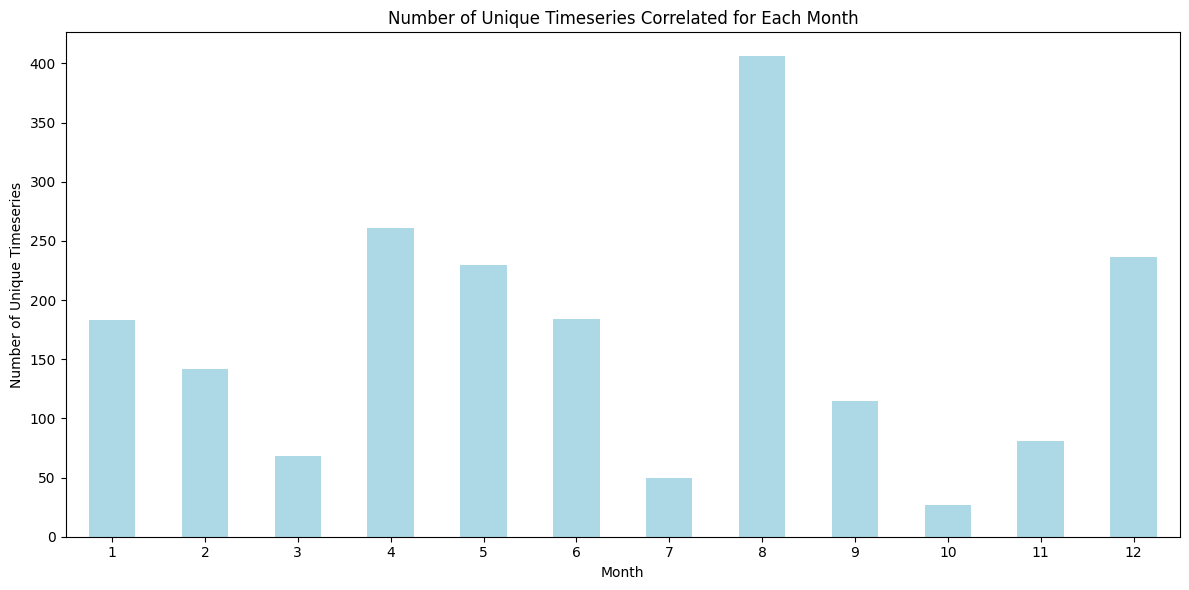

In [22]:
# Create a DataFrame to count unique timeseries appearances per month
unique_month_counts = all_correlations_df_chile.groupby(['Season', 'PC']).size().reset_index(name='Count')

# Set 'Count' to 1 to represent a unique appearance per timeseries per month
unique_month_counts['Count'] = 1

# Sum the number of unique timeseries for each month
timeseries_per_month = unique_month_counts.groupby('Season')['Count'].sum()

# Plot the number of timeseries that appear correlated for each month
plt.figure(figsize=(12, 6))
timeseries_per_month.plot(kind='bar', color='lightblue')
plt.title('Number of Unique Timeseries Correlated for Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Timeseries')
plt.xticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

As shown, there are a lot of potential predictors for each biseason excluding season 9 (August-September). Note that total predictors in this case is 744x3 = 2232. Remember each appearance is counted if a PC-mode combination correlates with any of the 5 HW indices.

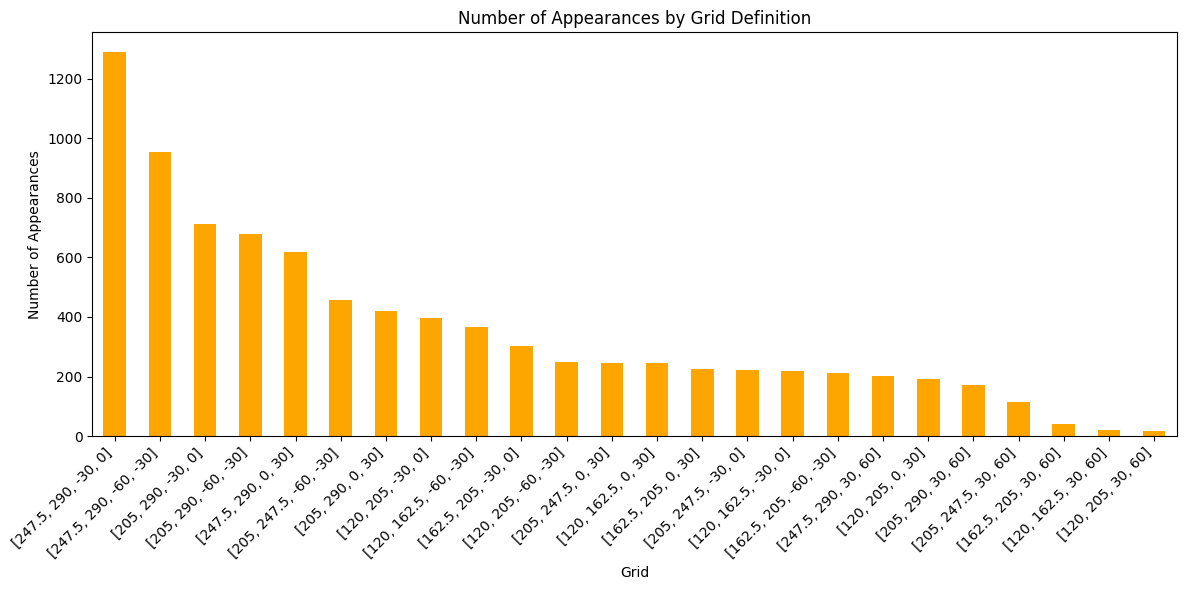

In [23]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df_chile['Grid'] = all_correlations_df_chile['ID'].map(lambda ts_id: pcas[int(ts_id)].box)

# Count the number of times each grid appears in the correlations DataFrame
grid_counts = all_correlations_df_chile['Grid'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
grid_counts.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Grid Definition')
plt.xlabel('Grid')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

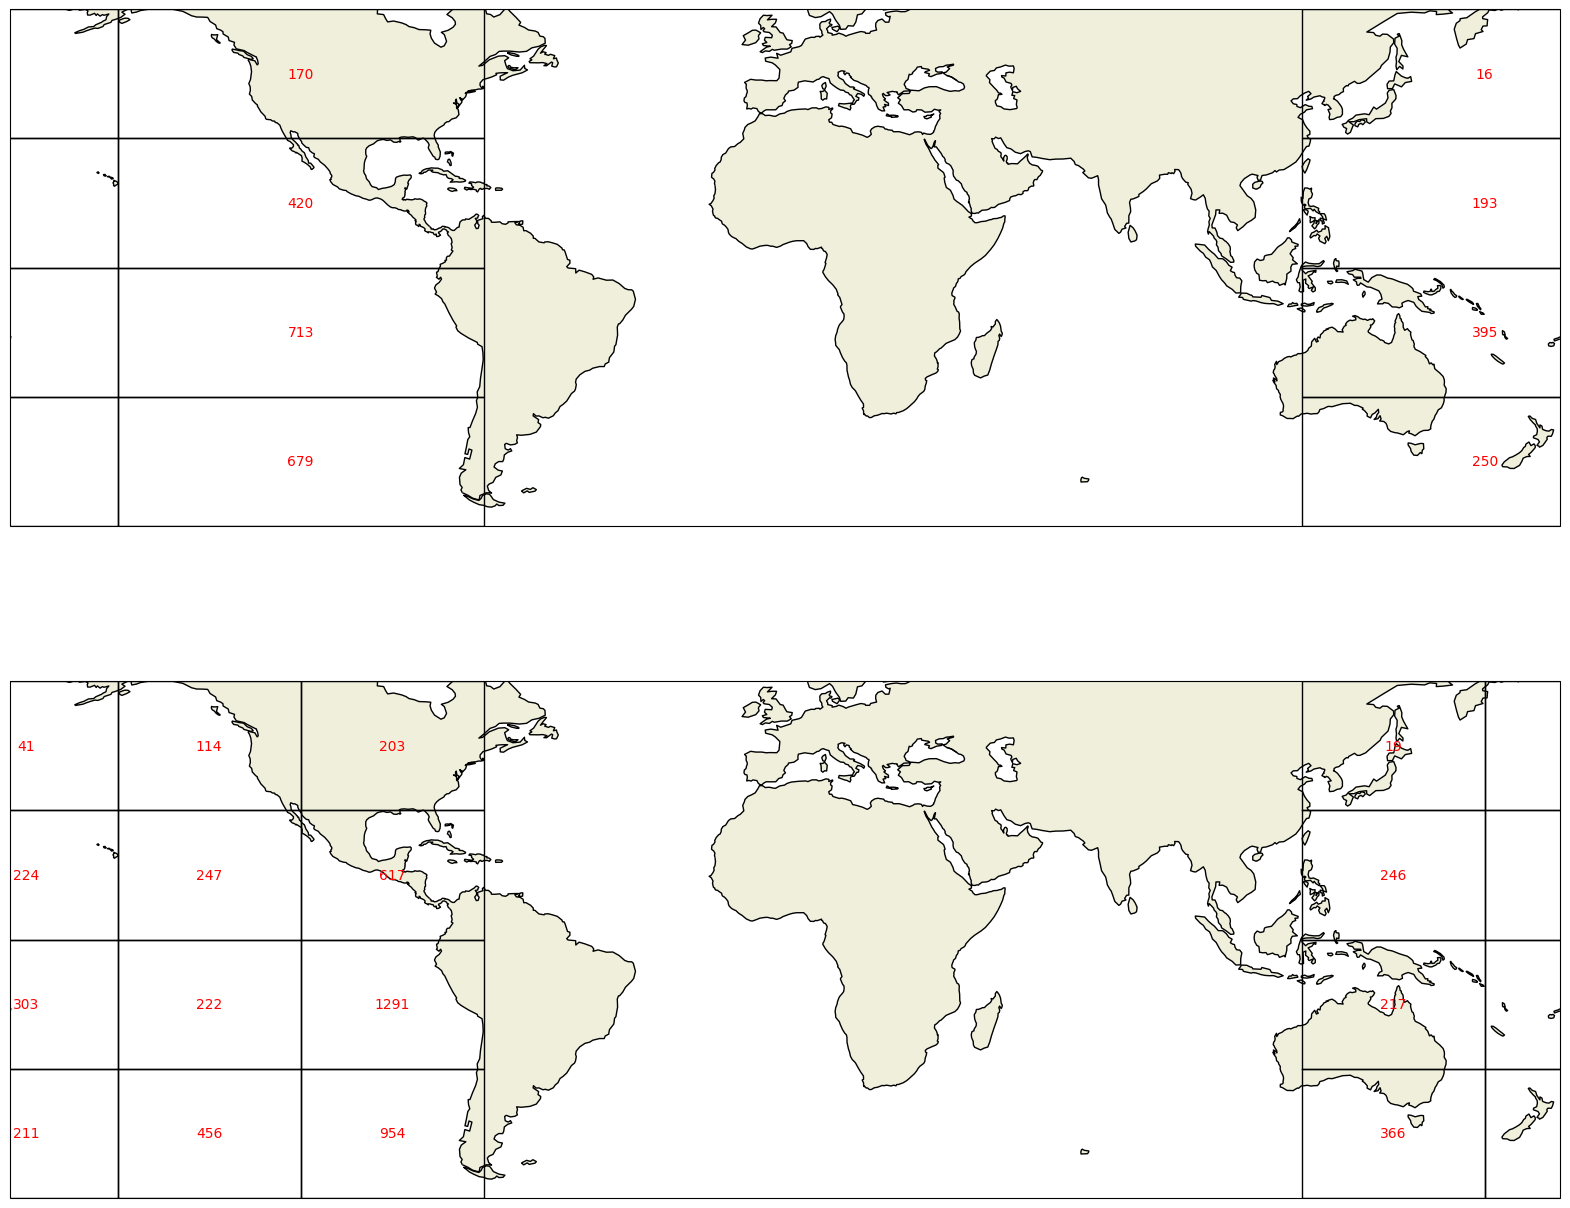

In [24]:
# Create a figure and axis
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())

# Set map extent
ax.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

# Add land and coastlines
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

# Plot the boxes and their counts
for grid, count in grid_counts.items():
    if grid in boxes1.values():
        min_lon, max_lon, min_lat, max_lat = grid
        
        ax.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                [min_lat, min_lat, max_lat, max_lat, min_lat],
                color='black', linewidth=1, transform=ccrs.PlateCarree())
        ax.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                str(count),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.PlateCarree(), color="r")
        

ax2.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

# Add land and coastlines
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.COASTLINE)

# Plot the boxes and their counts
for grid, count in grid_counts.items():
    if grid in boxes2.values():
        min_lon, max_lon, min_lat, max_lat = grid
        
        ax2.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                [min_lat, min_lat, max_lat, max_lat, min_lat],
                color='black', linewidth=1, transform=ccrs.PlateCarree())
        ax2.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                str(count),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.PlateCarree(), color="r")

plt.show()

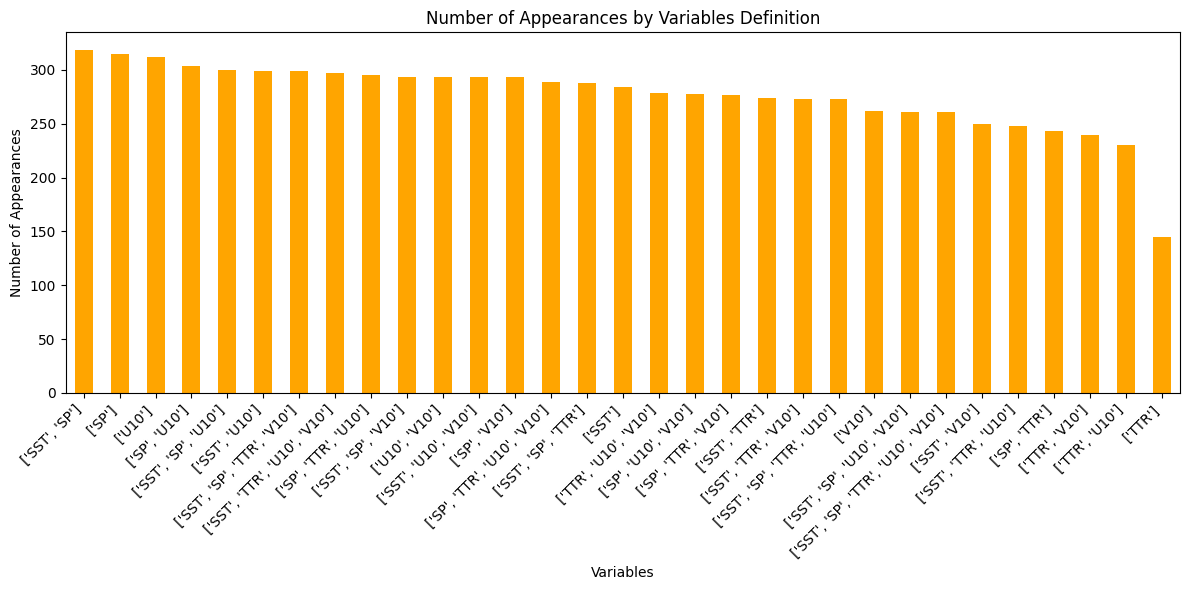

In [25]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df_chile['Variables'] = all_correlations_df_chile['ID'].map(lambda ts_id: str(list(pcas[int(ts_id)].variables_dict.values())))

# Count the number of times each grid appears in the correlations DataFrame
variables = all_correlations_df_chile['Variables'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
variables.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Variables Definition')
plt.xlabel('Variables')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

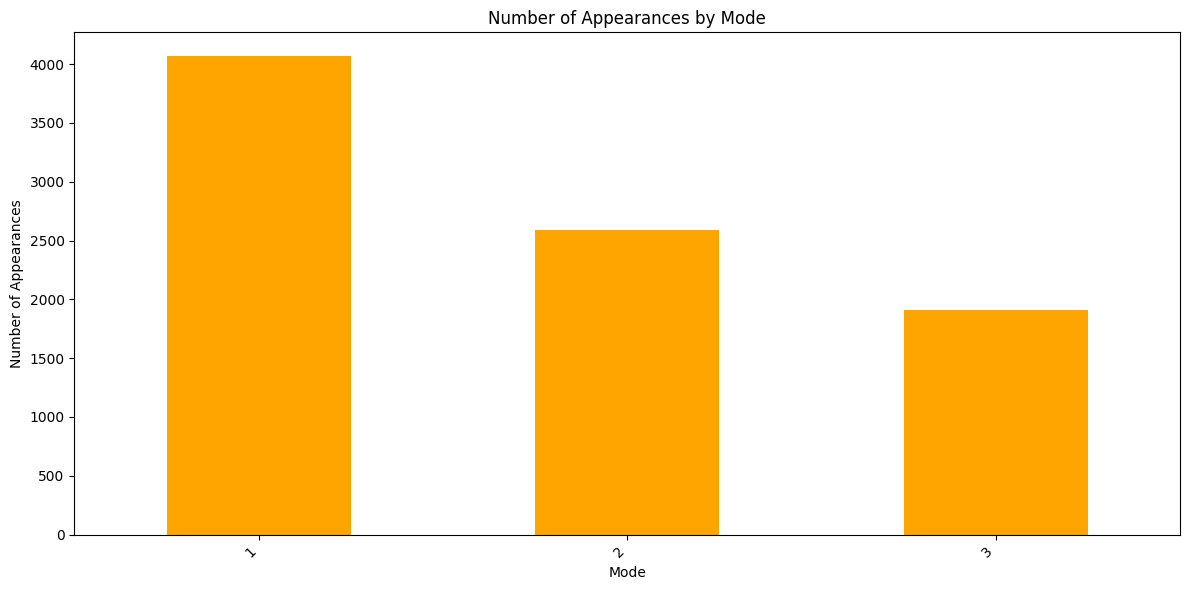

In [26]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df_chile['Mode'] = all_correlations_df_chile['PC'].map(lambda pc_str: int(pc_str[-1]))

# Count the number of times each grid appears in the correlations DataFrame
modes = all_correlations_df_chile['Mode'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
modes.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Mode')
plt.xlabel('Mode')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

### Average

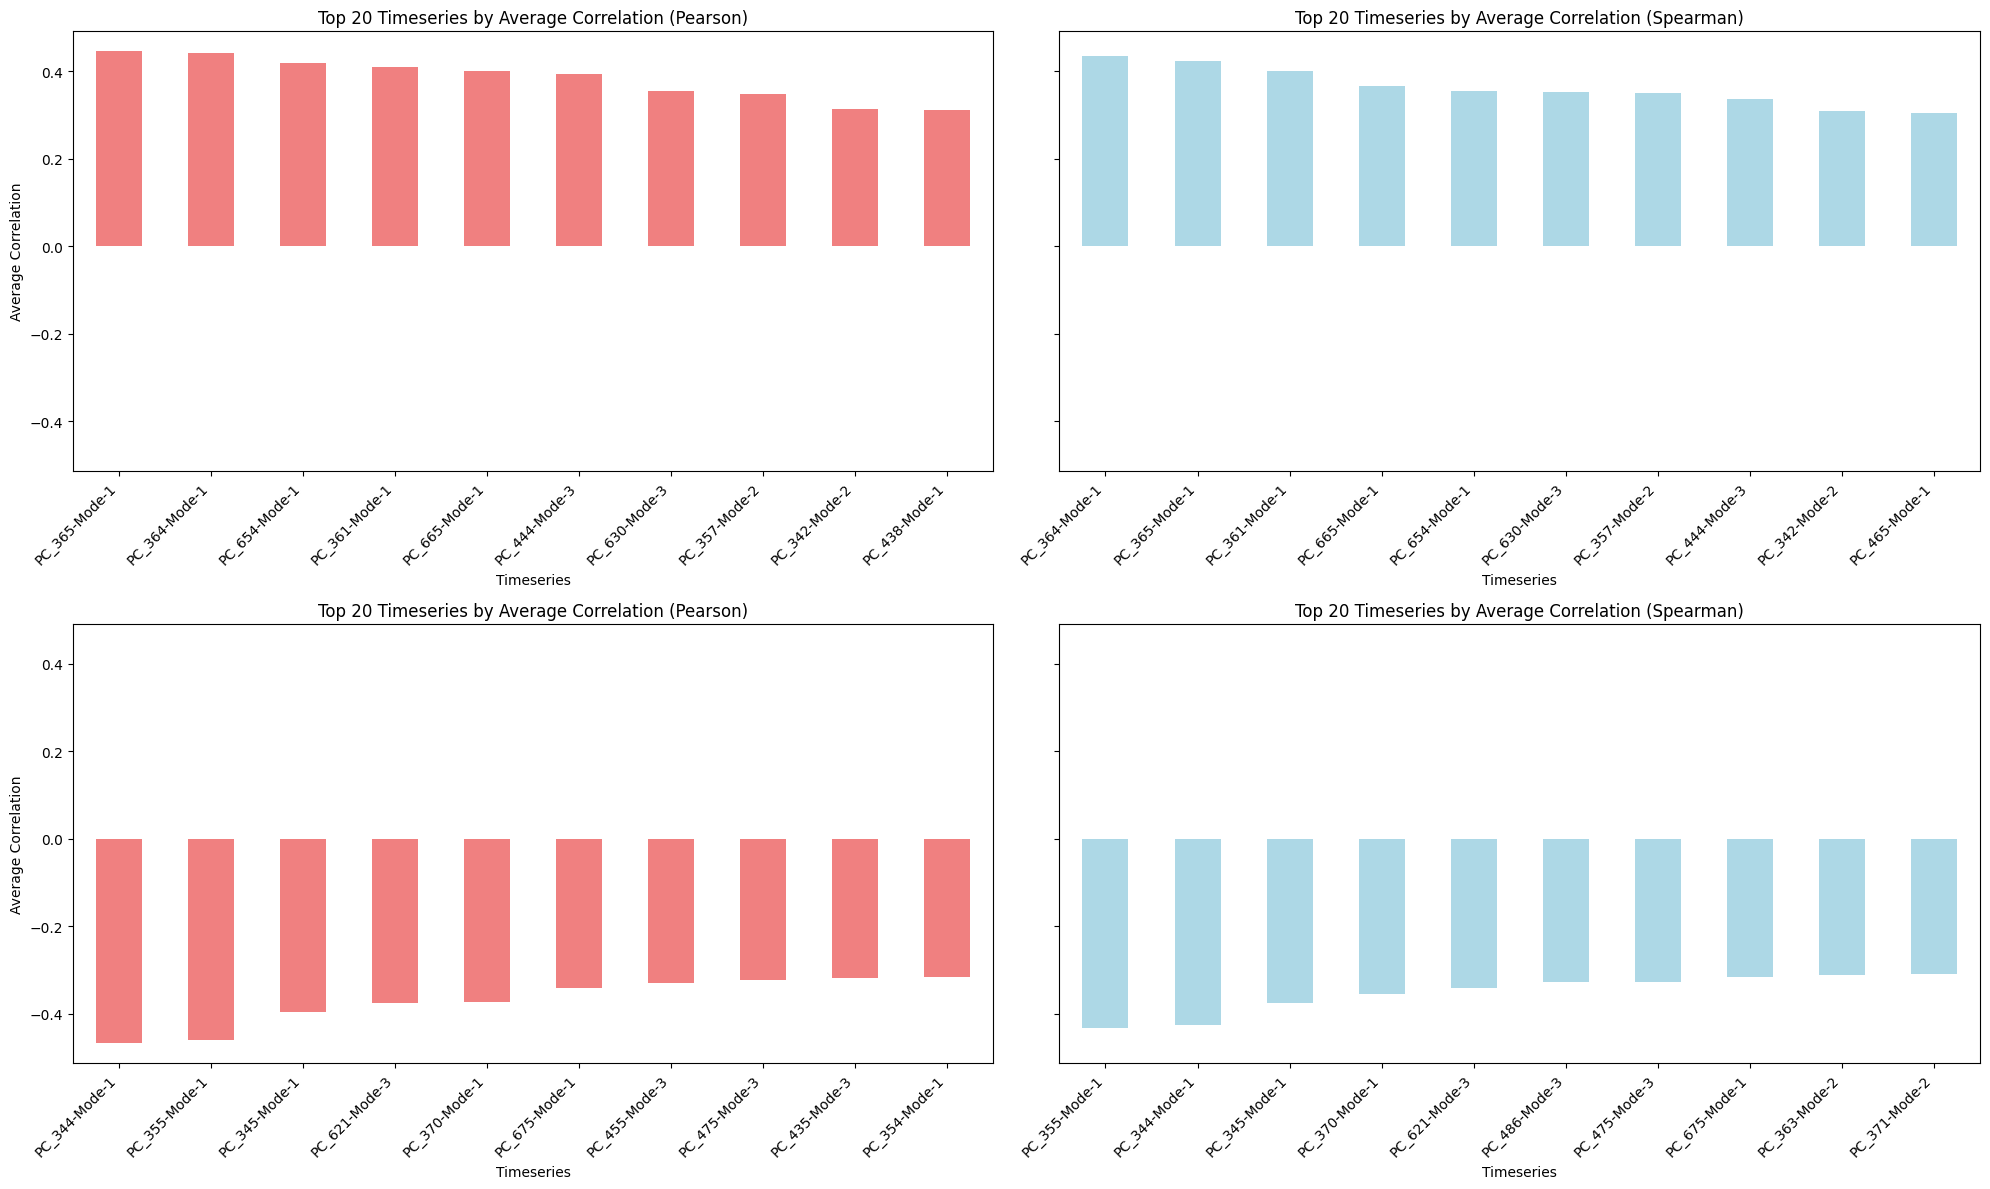

In [27]:
# Initialize a dictionary to store average correlations for each method
methods = ["pearson", "spearman"]
method_avg_correlation_top = {}
method_avg_correlation_low = {}


## IF we want abs() to ge
#any_correlations_df_chile["Correlation"] = abs(any_correlations_df_chile["Correlation"])

for method in methods:
    # Filter the DataFrame for the current method
    method_df = any_correlations_df_chile[any_correlations_df_chile['Method'] == method]

    # Calculate the average correlation for each timeseries
    method_avg_correlation_top[method] = method_df.groupby('PC')['Correlation'].mean().sort_values(ascending=False)
    method_avg_correlation_low[method] = method_df.groupby('PC')['Correlation'].mean().sort_values(ascending=True)

# Get the top 20 timeseries by average correlation for each method
top_20_avg_correlation = {
    method: correlations.head(10) for method, correlations in method_avg_correlation_top.items()
}
low_20_avg_correlation = {
    method: correlations.head(10) for method, correlations in method_avg_correlation_low.items()
}

# Plot the top 20 timeseries by average correlation for each method
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=True)

for i, method in enumerate(methods):
    ax = axes.flatten()[i]
    top_20_avg_correlation[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Average Correlation ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Average Correlation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    ax = axes.flatten()[i+2]
    low_20_avg_correlation[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Average Correlation ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Average Correlation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

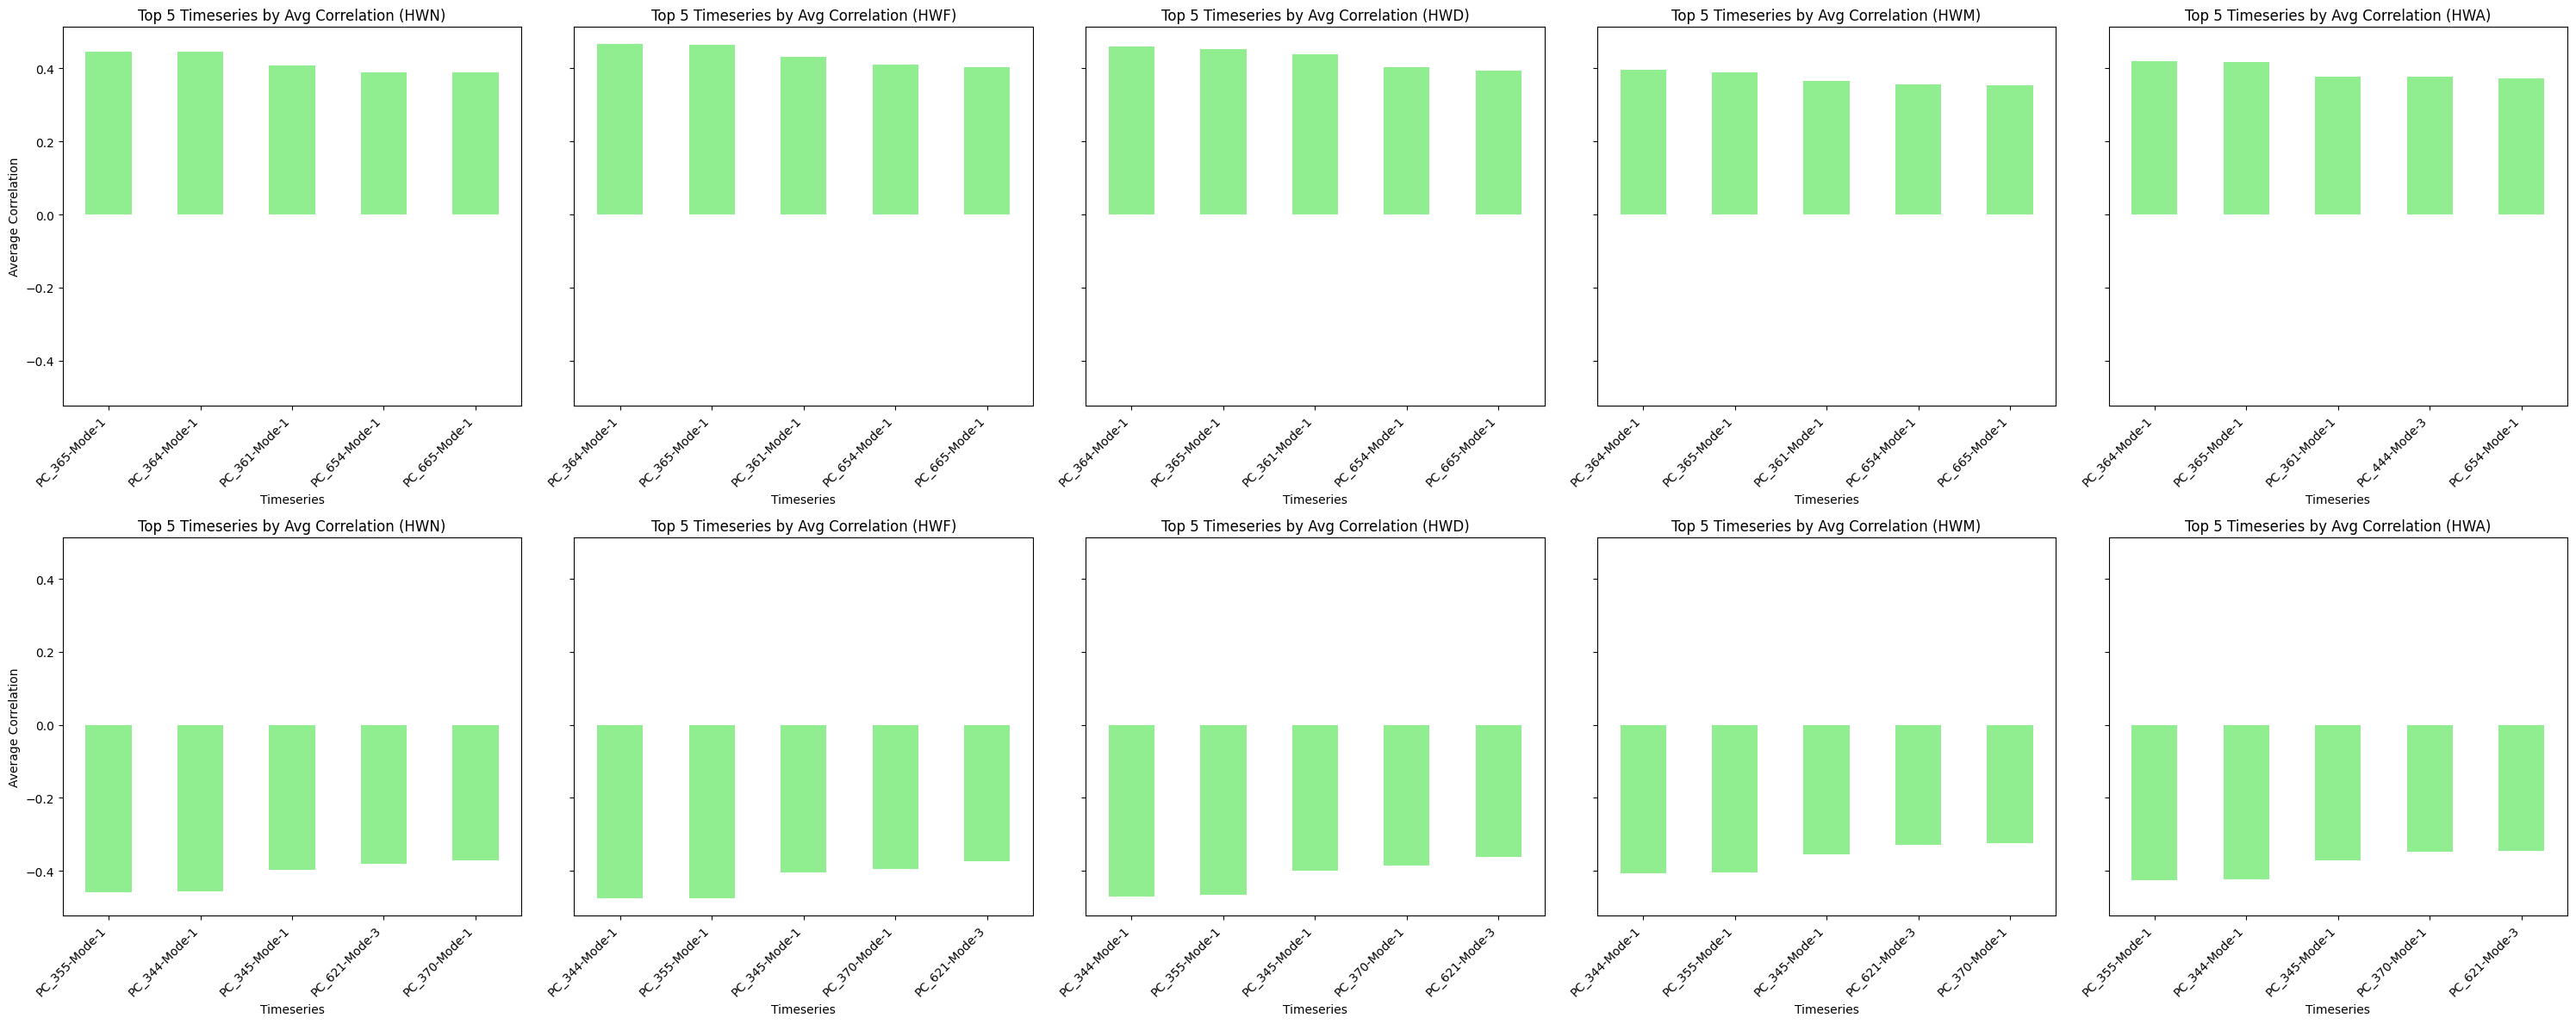

In [28]:
index_avg_correlation_top = {}
index_avg_correlation_low = {}


# Iterate over each index and compute average correlation
for index in indices_of_interest:
    # Filter the DataFrame for the current index
    index_df = any_correlations_df_chile[any_correlations_df_chile['Index'] == index]
    # Calculate the average correlation for each timeseries
    index_avg_correlation_top[index] = index_df.groupby('PC')['Correlation'].mean().sort_values(ascending=False)
    index_avg_correlation_low[index] = index_df.groupby('PC')['Correlation'].mean().sort_values(ascending=True)

# Get the top 20 timeseries by average correlation for each index
top_20_index_avg_correlation = {
    index: correlations.head(5) for index, correlations in index_avg_correlation_top.items()
}
low_20_index_avg_correlation = {
    index: correlations.head(5) for index, correlations in index_avg_correlation_low.items()
}

# Plot the top 20 timeseries by average correlation for each index
fig, axes = plt.subplots(2, 5, figsize=(30, 12), sharey=True)

for i, index in enumerate(indices_of_interest):
    ax = axes.flatten()[i]
    if index in top_20_index_avg_correlation:
        top_20_index_avg_correlation[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Avg Correlation ({index})')
        ax.set_xlabel('Timeseries')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Average Correlation')
    ax = axes.flatten()[i+5]
    if index in low_20_index_avg_correlation:
        low_20_index_avg_correlation[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Avg Correlation ({index})')
        ax.set_xlabel('Timeseries')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Average Correlation')


plt.tight_layout()
plt.show()

## California

In [29]:
first_year = 1990
hwis_cali = hwis_cali[(hwis_cali.index.year <= 2022) & (hwis_cali.index.year >= first_year)]

for mode in range(pcas[0].n_modes):
    for num, pca in pcas.items():
        hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)

C:\Users\marti\AppData\Local\Temp\ipykernel_16776\4233658634.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_16776\4233658634.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_16776\4233658634.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [30]:
indices_of_interest = ["HWN", "HWF", "HWD", "HWM", "HWA"]

season_correlations_cali = {}
seasons_any_corr_cali = {}

for i in range(12):
    hwis_month = hwis_cali[hwis_cali.index.month == i+1]
    correlations = {
    "pearson": compute_correlations(hwis_month),
    "spearman": compute_correlations(hwis_month, method='spearman')
    }

    # Initialize dictionaries to hold positive and negative correlations
    strong_correlations = {
        "positive": {"pearson": [], "spearman": []},
        "negative": {"pearson": [], "spearman": []}
    }
    any_correlations = {
        "positive": {"pearson": [], "spearman": []},
        "negative": {"pearson": [], "spearman": []}
    }

    # Iterate over each correlation matrix and collect pairs
    for method, corr_df in correlations.items():
        for timeserie, row in corr_df.iterrows():
            for index, value in row.items():
                if value > 0.5:
                    strong_correlations["positive"][method].append((timeserie, index, value))
                elif value < -0.5:
                    strong_correlations["negative"][method].append((timeserie, index, value))
                if value > 0:
                    any_correlations["positive"][method].append((timeserie, index, value))
                elif value < 0:
                    any_correlations["negative"][method].append((timeserie, index, value))

    # Convert to DataFrames for easy viewing and saving
    positive_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["positive"].items()
    }
    negative_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["negative"].items()
    }
    positive_corr_any_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in any_correlations["positive"].items()
    }
    negative_corr_any_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in any_correlations["negative"].items()
    }
    season_correlations_cali[i+1] = [positive_corr_df, negative_corr_df]
    seasons_any_corr_cali[i+1] = [positive_corr_any_df, negative_corr_any_df]
    print("Ready season", i+1)



Ready season 1
Ready season 2
Ready season 3
Ready season 4
Ready season 5
Ready season 6
Ready season 7
Ready season 8
Ready season 9
Ready season 10
Ready season 11
Ready season 12


In [31]:
# Initialize a list to collect all correlations from all months and methods
all_correlations = []

# Iterate through each month in the season_correlations_chile dictionary
for month, (positive_corr_dict, negative_corr_dict) in season_correlations_cali.items():
    # Combine positive and negative correlations for each method
    for method in ["pearson", "spearman"]:
        if method in positive_corr_dict:
            for _, row in positive_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))
        
        if method in negative_corr_dict:
            for _, row in negative_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))

# Convert the collected data to a DataFrame for easier processing
all_correlations_df_cali = pd.DataFrame(
    all_correlations, columns=["Season", "Method", "PC", "Index", "Correlation"]
)
all_correlations_df_cali['ID'] = all_correlations_df_cali['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))

## Include explained variance
all_correlations_df_cali['Variance'] = all_correlations_df_cali.apply(lambda x: pcas[int(x.ID)].explained_variance[str(x.Season)][int(x.PC[-1])-1], axis=1)

top_correlations = all_correlations_df_cali.reindex(
    all_correlations_df_cali["Correlation"].abs().sort_values(ascending=False).index
).head(30)

print(top_correlations)

      Season    Method             PC Index  Correlation   ID  Variance
3645       7  spearman  PC_371-Mode-2   HWD    -0.801202  371  0.176542
3514       7  spearman  PC_368-Mode-2   HWD     0.798785  368  0.200610
3644       7  spearman  PC_371-Mode-2   HWF    -0.797068  371  0.176542
3513       7  spearman  PC_368-Mode-2   HWF     0.792580  368  0.200610
3254       7   pearson  PC_368-Mode-2   HWD     0.791540  368  0.200610
3253       7   pearson  PC_368-Mode-2   HWF     0.784968  368  0.200610
3252       7   pearson  PC_368-Mode-2   HWN     0.782746  368  0.200610
565        2   pearson  PC_554-Mode-2   HWN     0.772009  554  0.143075
3504       7  spearman  PC_364-Mode-2   HWD     0.768215  364  0.206131
3519       7  spearman  PC_370-Mode-2   HWD     0.767179  370  0.169676
3245       7   pearson  PC_364-Mode-2   HWD     0.767175  364  0.206131
3643       7  spearman  PC_371-Mode-2   HWN    -0.763833  371  0.176542
3259       7   pearson  PC_370-Mode-2   HWD     0.763400  370  0

In [32]:
# Initialize a list to collect all correlations from all months and methods
any_correlations_list = []

# Iterate through each month in the season_correlations_chile dictionary
for month, (positive_corr_dict, negative_corr_dict) in seasons_any_corr_cali.items():
    # Combine positive and negative correlations for each method
    for method in ["pearson", "spearman"]:
        if method in positive_corr_dict:
            for _, row in positive_corr_dict[method].iterrows():
                any_correlations_list.append((month, method, *row))
        
        if method in negative_corr_dict:
            for _, row in negative_corr_dict[method].iterrows():
                any_correlations_list.append((month, method, *row))

# Convert the collected data to a DataFrame for easier processing
any_correlations_df_cali = pd.DataFrame(
    any_correlations_list, columns=["Season", "Method", "PC", "Index", "Correlation"]
)
any_correlations_df_cali['ID'] = any_correlations_df_cali['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))

PC_371 is on Box [247.5, 290, -30, 0] with variables ['SST', 'SP', 'TTR', 'U10', 'V10']


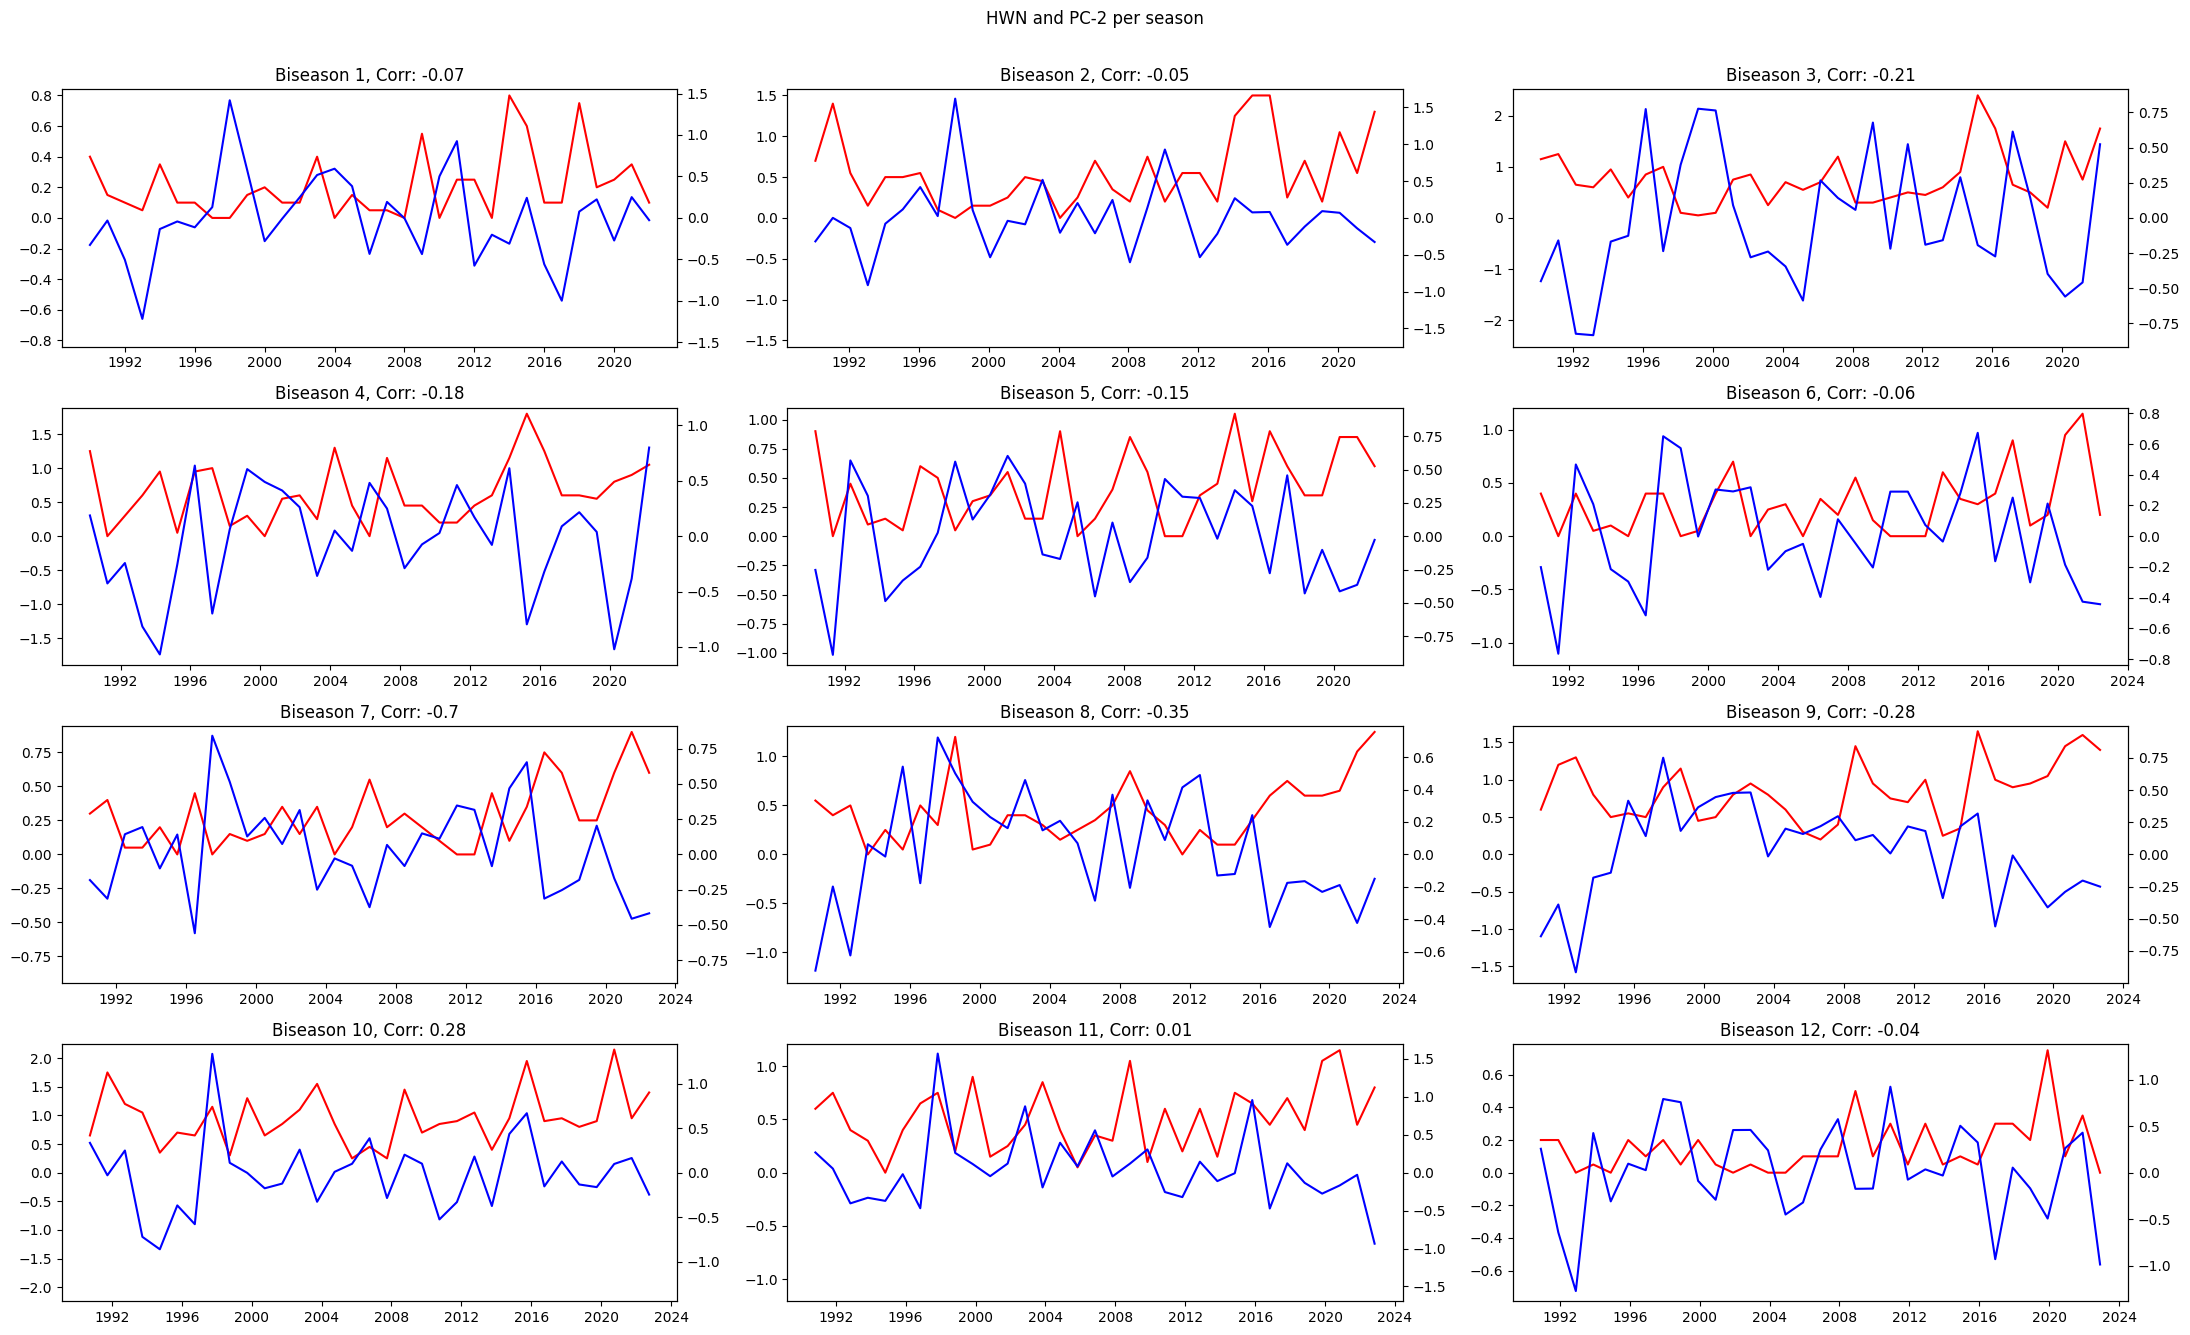

In [33]:
top1 = int(list(top_correlations["ID"])[0])
mode_top1 = int(list(top_correlations["PC"])[0][-1])
print(f"PC_{top1} is on Box {pcas[top1].box} with variables {list(pcas[top1].variables_dict.values())}")
plot_hw_index_by_season(hwis_cali, "HWN", pcas[top1], mode_top1, start=first_year)

### Appearances

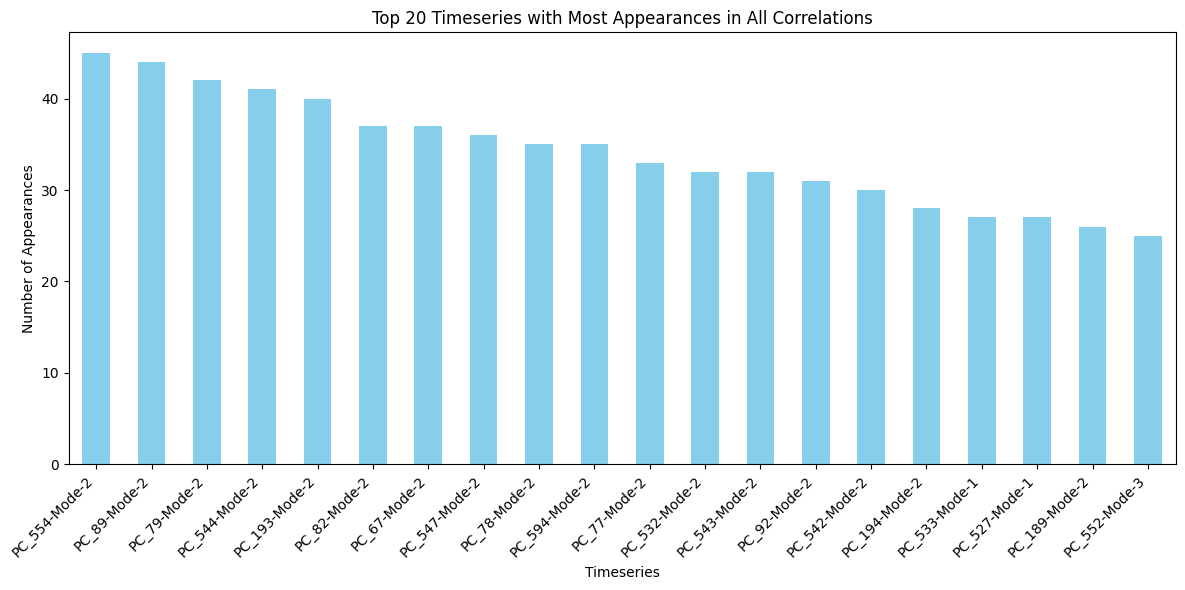

In [34]:
timeseries_count = all_correlations_df_cali['PC'].value_counts()

# Get the top 20 most frequent timeseries
top_20_timeseries = timeseries_count.head(20)

plt.figure(figsize=(12, 6))
top_20_timeseries.plot(kind='bar', color='skyblue')
plt.title('Top 20 Timeseries with Most Appearances in All Correlations')
plt.xlabel('Timeseries')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

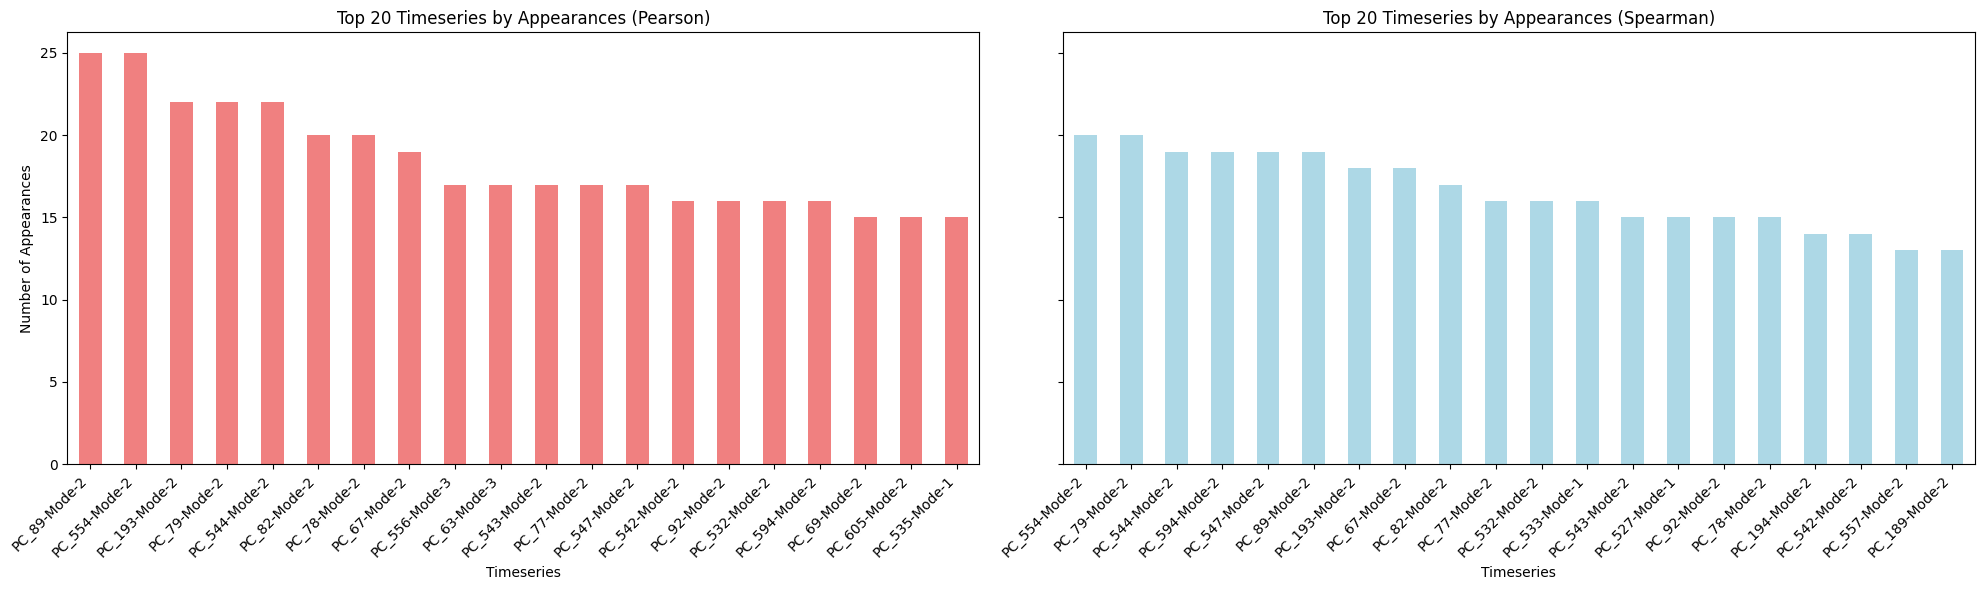

In [35]:
# Filter and count appearances for each method
methods = ["pearson", "spearman"]
method_counts = {}

for method in methods:
    # Filter the DataFrame for the current method
    method_df = all_correlations_df_cali[all_correlations_df_cali['Method'] == method]
    # Count the frequency of each timeseries in the 'Timeserie' column
    method_counts[method] = method_df['PC'].value_counts()

# Get the top 20 timeseries for each method
top_20_counts = {
    method: counts.head(20) for method, counts in method_counts.items()
}

# Plot the top 20 timeseries for each method
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

for i, method in enumerate(methods):
    ax = axes[i]
    top_20_counts[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Appearances ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Number of Appearances')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

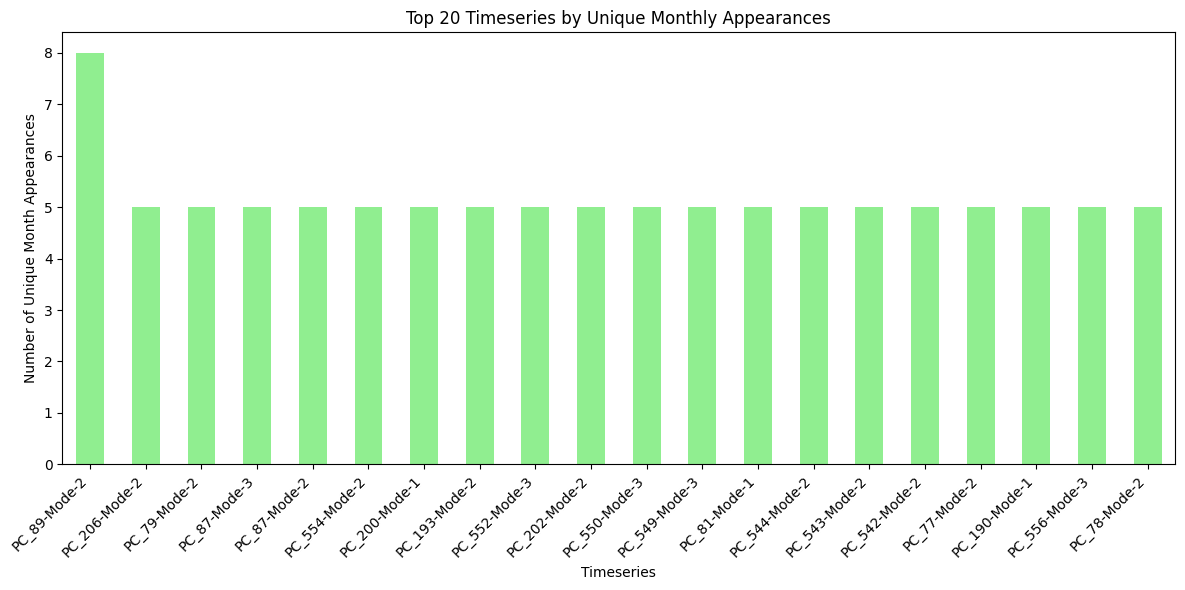

In [36]:
# Create a DataFrame to store unique appearances by month
unique_monthly_counts = all_correlations_df_cali.groupby(['Season', 'PC']).size().reset_index(name='Count')

# Remove duplicate timeseries per month by setting 'Count' to 1 where it exists
unique_monthly_counts['Count'] = 1

# Count how many times each timeseries appears across all months (unique per month)
total_unique_counts = unique_monthly_counts.groupby('PC')['Count'].sum()

# Get the top 20 timeseries by the number of unique month appearances
top_20_unique_timeseries = total_unique_counts.sort_values(ascending=False).head(20)

# Plot the top 20 timeseries in a bar plot
plt.figure(figsize=(12, 6))
top_20_unique_timeseries.plot(kind='bar', color='lightgreen')
plt.title('Top 20 Timeseries by Unique Monthly Appearances')
plt.xlabel('Timeseries')
plt.ylabel('Number of Unique Month Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

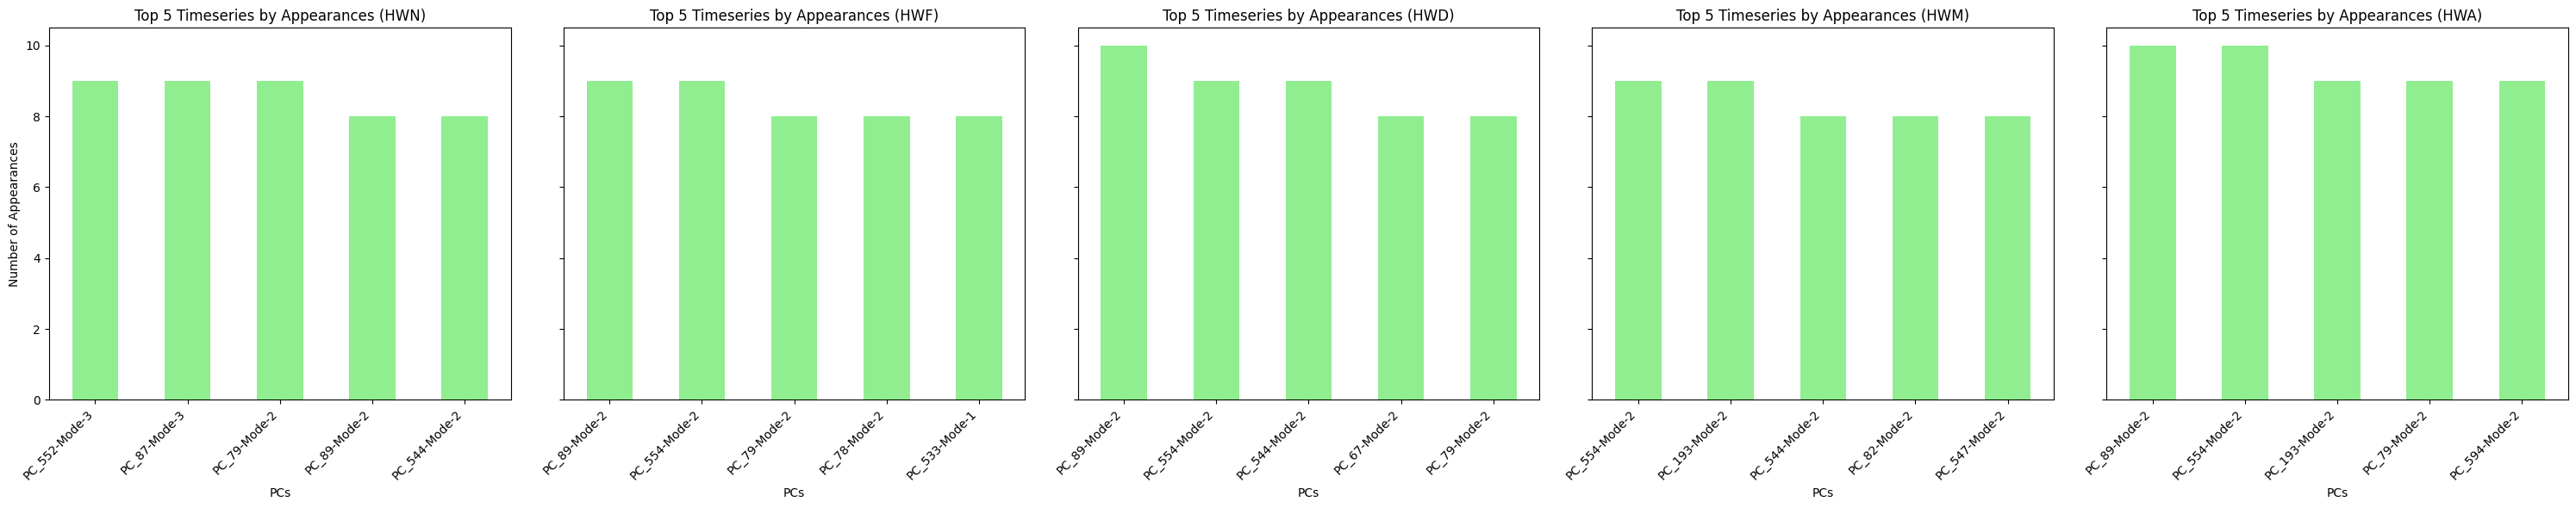

In [37]:
# Initialize a dictionary to store counts for each index
index_counts = {}

# Iterate over each index and count appearances
for index in indices_of_interest:
    # Filter the DataFrame for the current index
    index_df = all_correlations_df_cali[all_correlations_df_cali['Index'] == index]
    # Count the frequency of each timeseries in the 'Timeserie' column
    index_counts[index] = index_df['PC'].value_counts()

# Get the top 20 timeseries for each index
top_20_index_counts = {
    index: counts.head(5) for index, counts in index_counts.items()
}

# Plot the top 20 timeseries for each index
fig, axes = plt.subplots(1, 5, figsize=(30, 6), sharey=True)

for i, index in enumerate(indices_of_interest):
    ax = axes[i]
    if index in top_20_index_counts:
        top_20_index_counts[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Appearances ({index})')
        ax.set_xlabel('PCs')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Number of Appearances')

plt.tight_layout()
plt.show()


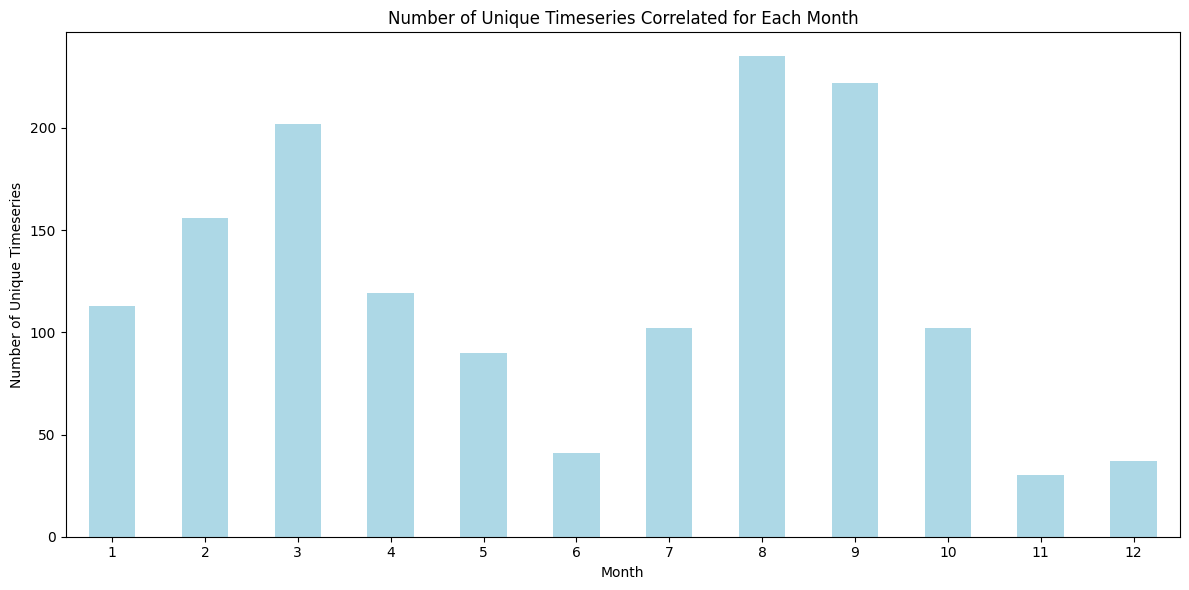

In [38]:
# Create a DataFrame to count unique timeseries appearances per month
unique_month_counts = all_correlations_df_cali.groupby(['Season', 'PC']).size().reset_index(name='Count')

# Set 'Count' to 1 to represent a unique appearance per timeseries per month
unique_month_counts['Count'] = 1

# Sum the number of unique timeseries for each month
timeseries_per_month = unique_month_counts.groupby('Season')['Count'].sum()

# Plot the number of timeseries that appear correlated for each month
plt.figure(figsize=(12, 6))
timeseries_per_month.plot(kind='bar', color='lightblue')
plt.title('Number of Unique Timeseries Correlated for Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Timeseries')
plt.xticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

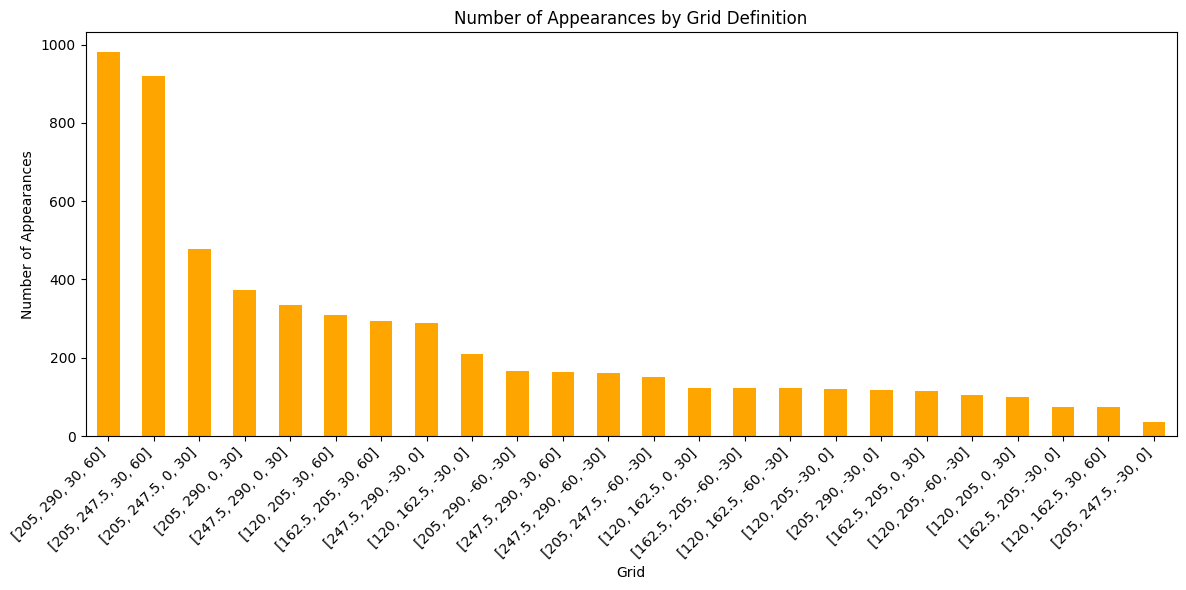

In [39]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df_cali['Grid'] = all_correlations_df_cali['ID'].map(lambda ts_id: pcas[int(ts_id)].box)

# Count the number of times each grid appears in the correlations DataFrame
grid_counts = all_correlations_df_cali['Grid'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
grid_counts.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Grid Definition')
plt.xlabel('Grid')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

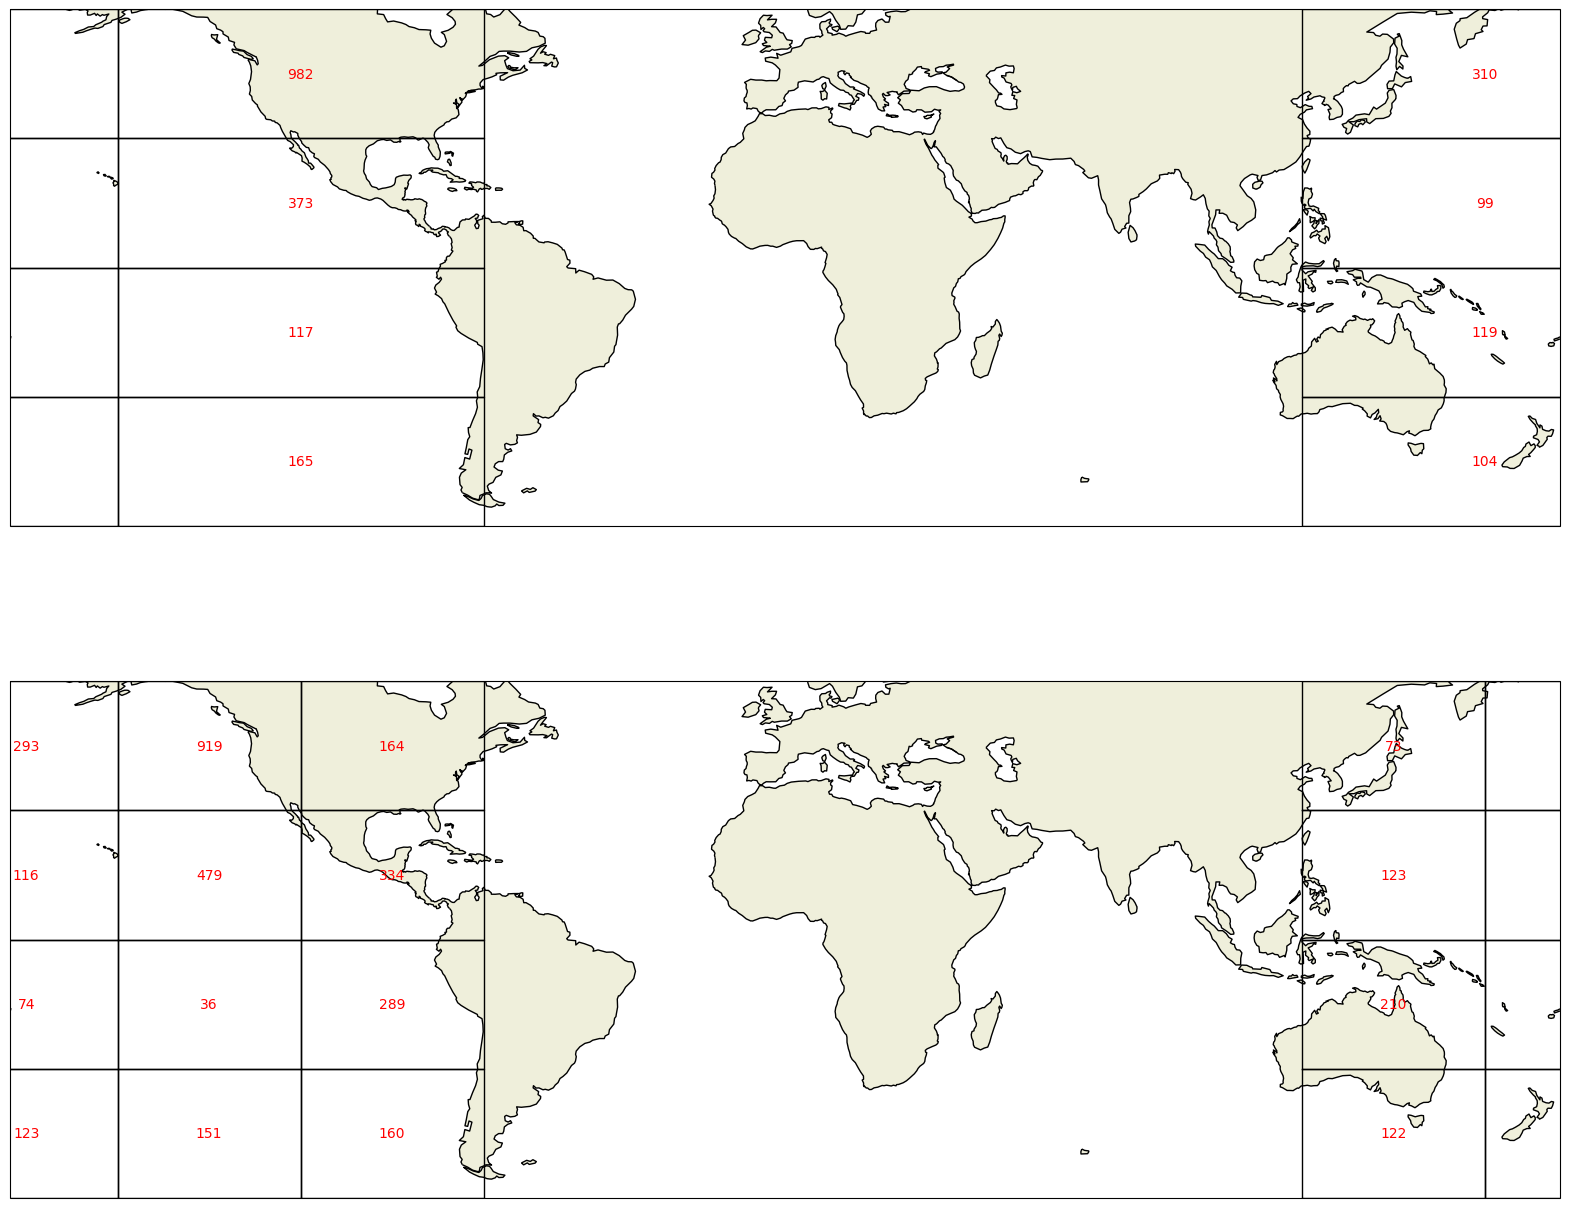

In [40]:
# Create a figure and axis
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())

# Set map extent
ax.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

# Add land and coastlines
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

# Plot the boxes and their counts
for grid, count in grid_counts.items():
    if grid in boxes1.values():
        min_lon, max_lon, min_lat, max_lat = grid
        
        ax.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                [min_lat, min_lat, max_lat, max_lat, min_lat],
                color='black', linewidth=1, transform=ccrs.PlateCarree())
        ax.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                str(count),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.PlateCarree(), color="r")
        

ax2.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

# Add land and coastlines
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.COASTLINE)

# Plot the boxes and their counts
for grid, count in grid_counts.items():
    if grid in boxes2.values():
        min_lon, max_lon, min_lat, max_lat = grid
        
        ax2.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                [min_lat, min_lat, max_lat, max_lat, min_lat],
                color='black', linewidth=1, transform=ccrs.PlateCarree())
        ax2.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                str(count),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.PlateCarree(), color="r")

plt.show()

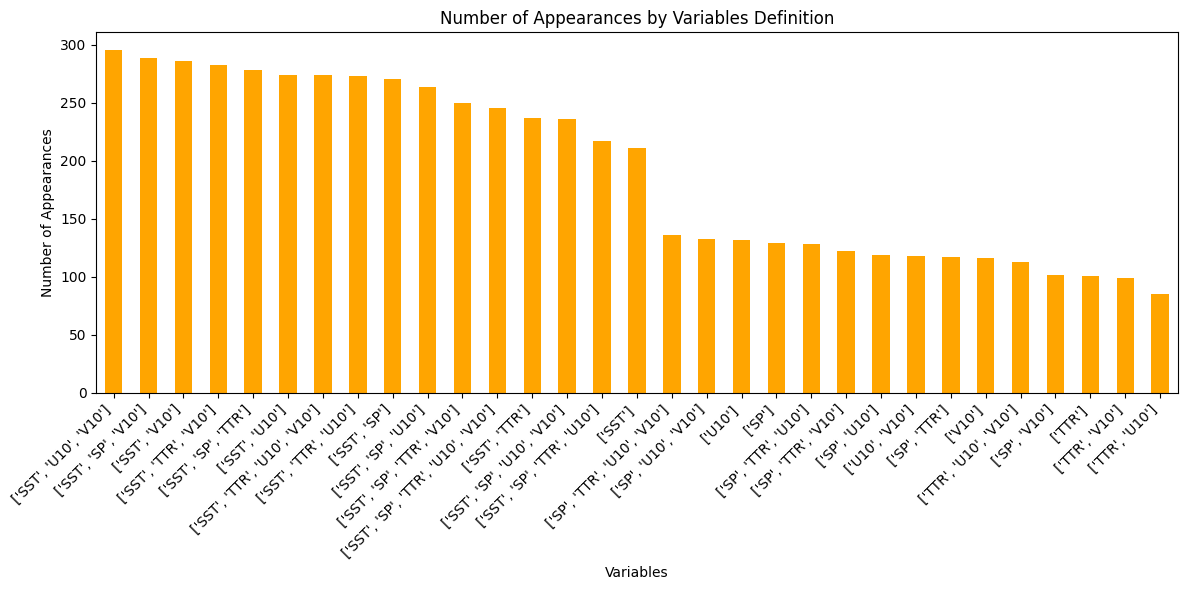

In [41]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df_cali['Variables'] = all_correlations_df_cali['ID'].map(lambda ts_id: str(list(pcas[int(ts_id)].variables_dict.values())))

# Count the number of times each grid appears in the correlations DataFrame
variables = all_correlations_df_cali['Variables'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
variables.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Variables Definition')
plt.xlabel('Variables')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

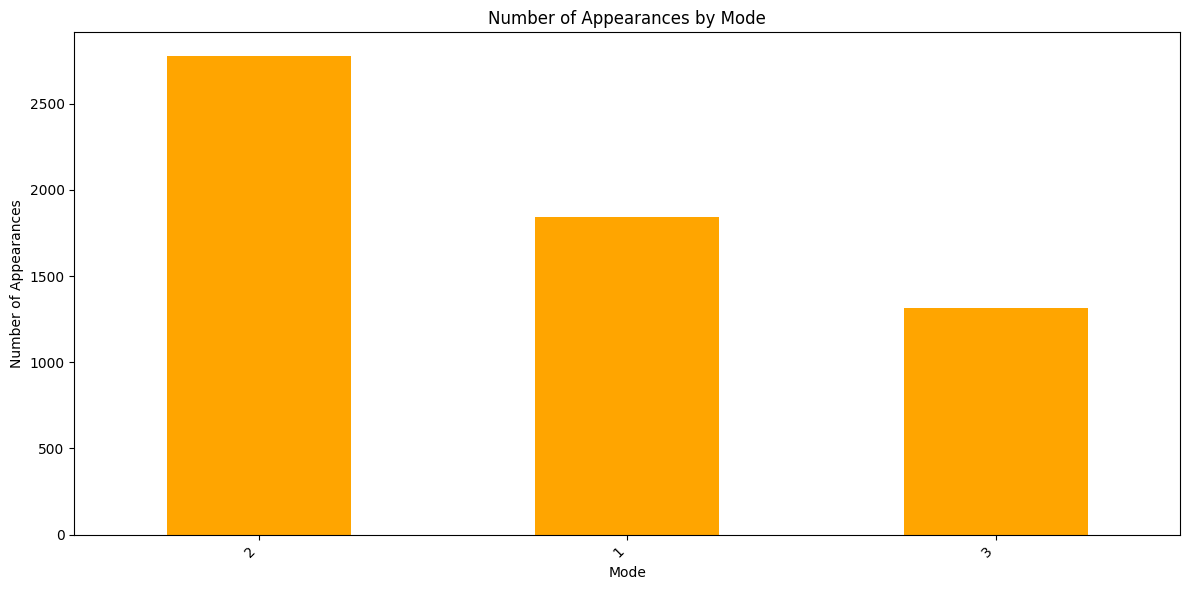

In [42]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df_cali['Mode'] = all_correlations_df_cali['PC'].map(lambda pc_str: int(pc_str[-1]))

# Count the number of times each grid appears in the correlations DataFrame
modes = all_correlations_df_cali['Mode'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
modes.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Mode')
plt.xlabel('Mode')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

### Average

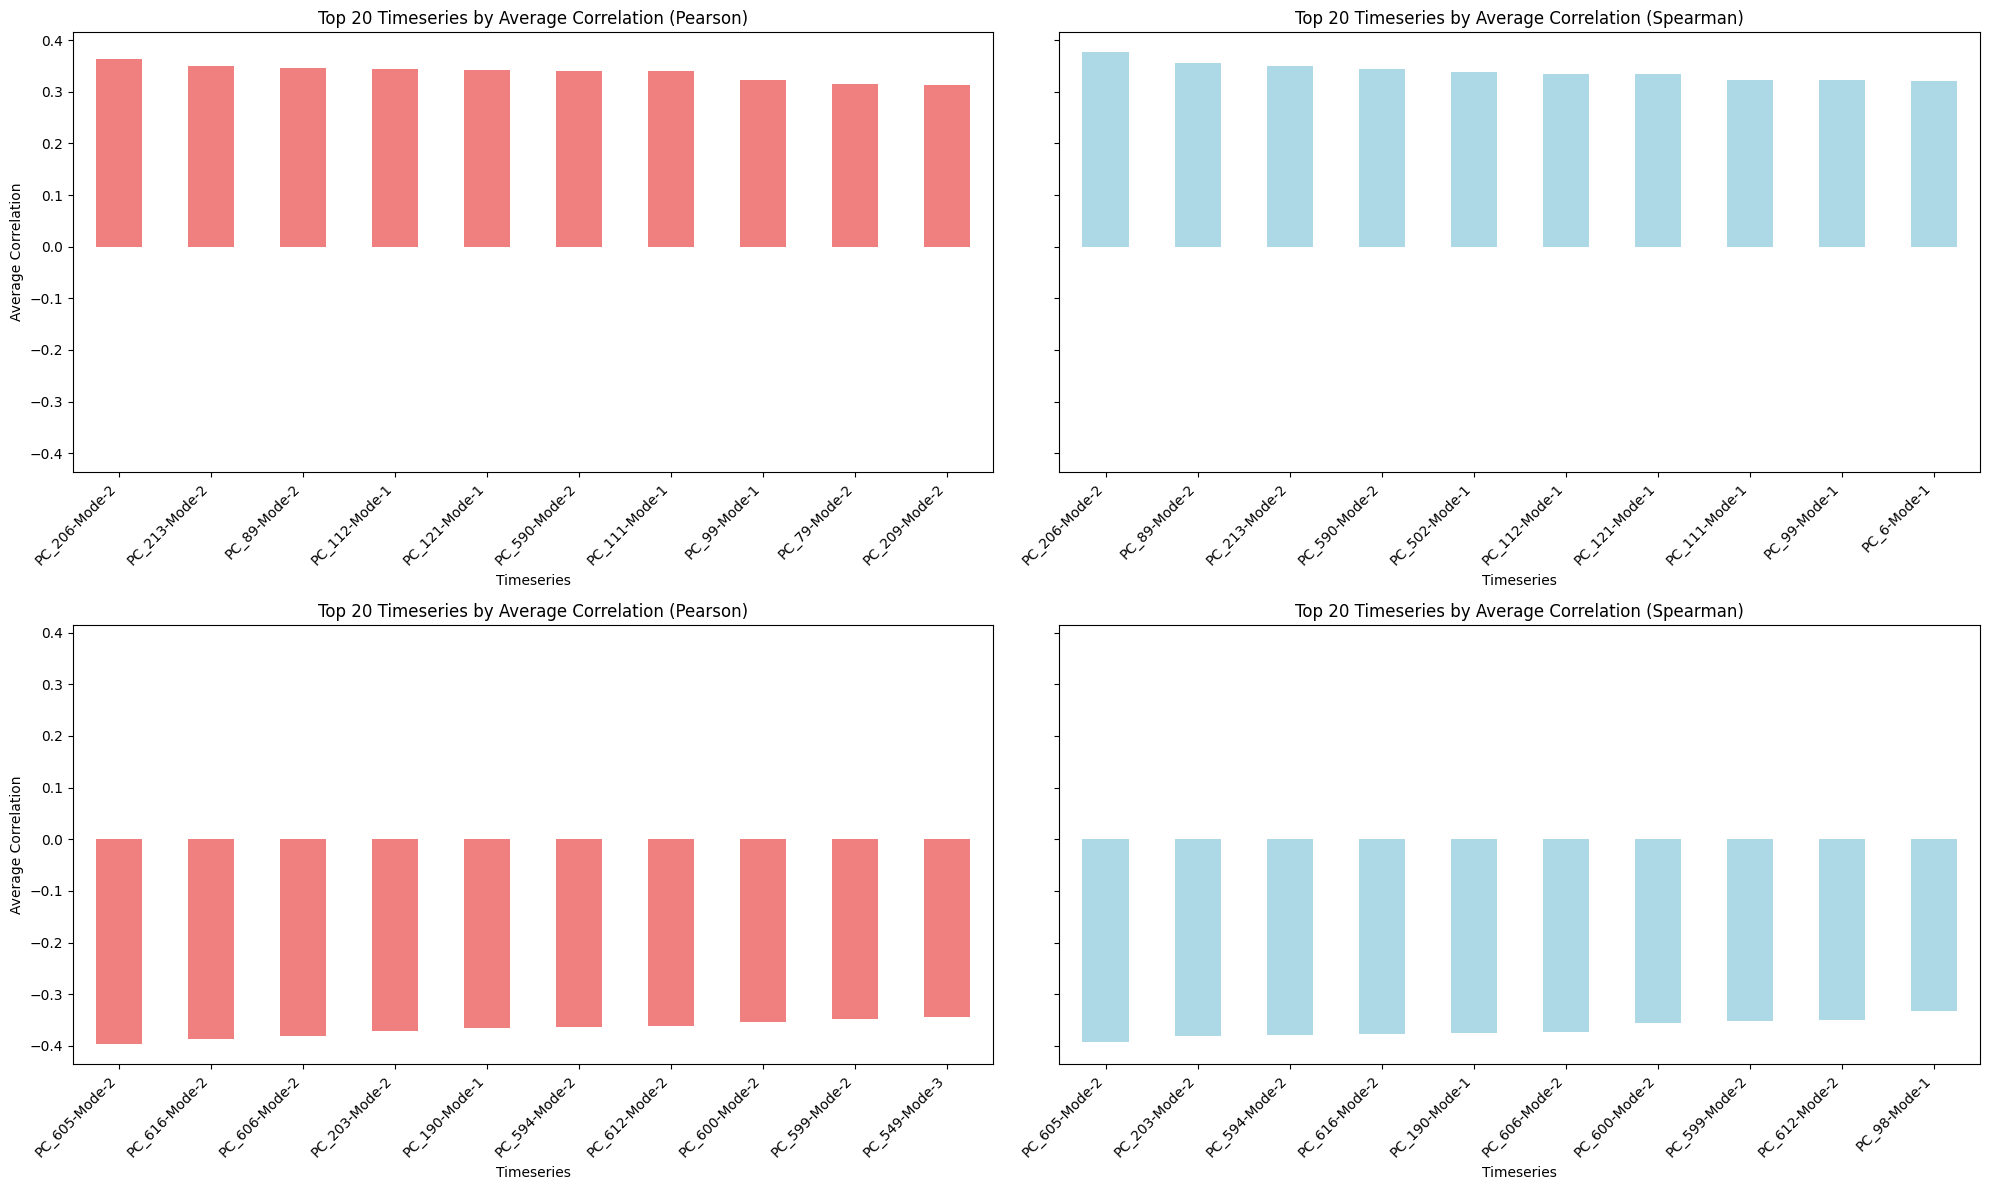

In [43]:
# Initialize a dictionary to store average correlations for each method
methods = ["pearson", "spearman"]
method_avg_correlation_top = {}
method_avg_correlation_low = {}


## IF we want abs() to ge
#any_correlations_df_chile["Correlation"] = abs(any_correlations_df_chile["Correlation"])

for method in methods:
    # Filter the DataFrame for the current method
    method_df = any_correlations_df_cali[any_correlations_df_cali['Method'] == method]

    # Calculate the average correlation for each timeseries
    method_avg_correlation_top[method] = method_df.groupby('PC')['Correlation'].mean().sort_values(ascending=False)
    method_avg_correlation_low[method] = method_df.groupby('PC')['Correlation'].mean().sort_values(ascending=True)

# Get the top 20 timeseries by average correlation for each method
top_20_avg_correlation = {
    method: correlations.head(10) for method, correlations in method_avg_correlation_top.items()
}
low_20_avg_correlation = {
    method: correlations.head(10) for method, correlations in method_avg_correlation_low.items()
}

# Plot the top 20 timeseries by average correlation for each method
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=True)

for i, method in enumerate(methods):
    ax = axes.flatten()[i]
    top_20_avg_correlation[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Average Correlation ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Average Correlation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    ax = axes.flatten()[i+2]
    low_20_avg_correlation[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Average Correlation ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Average Correlation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

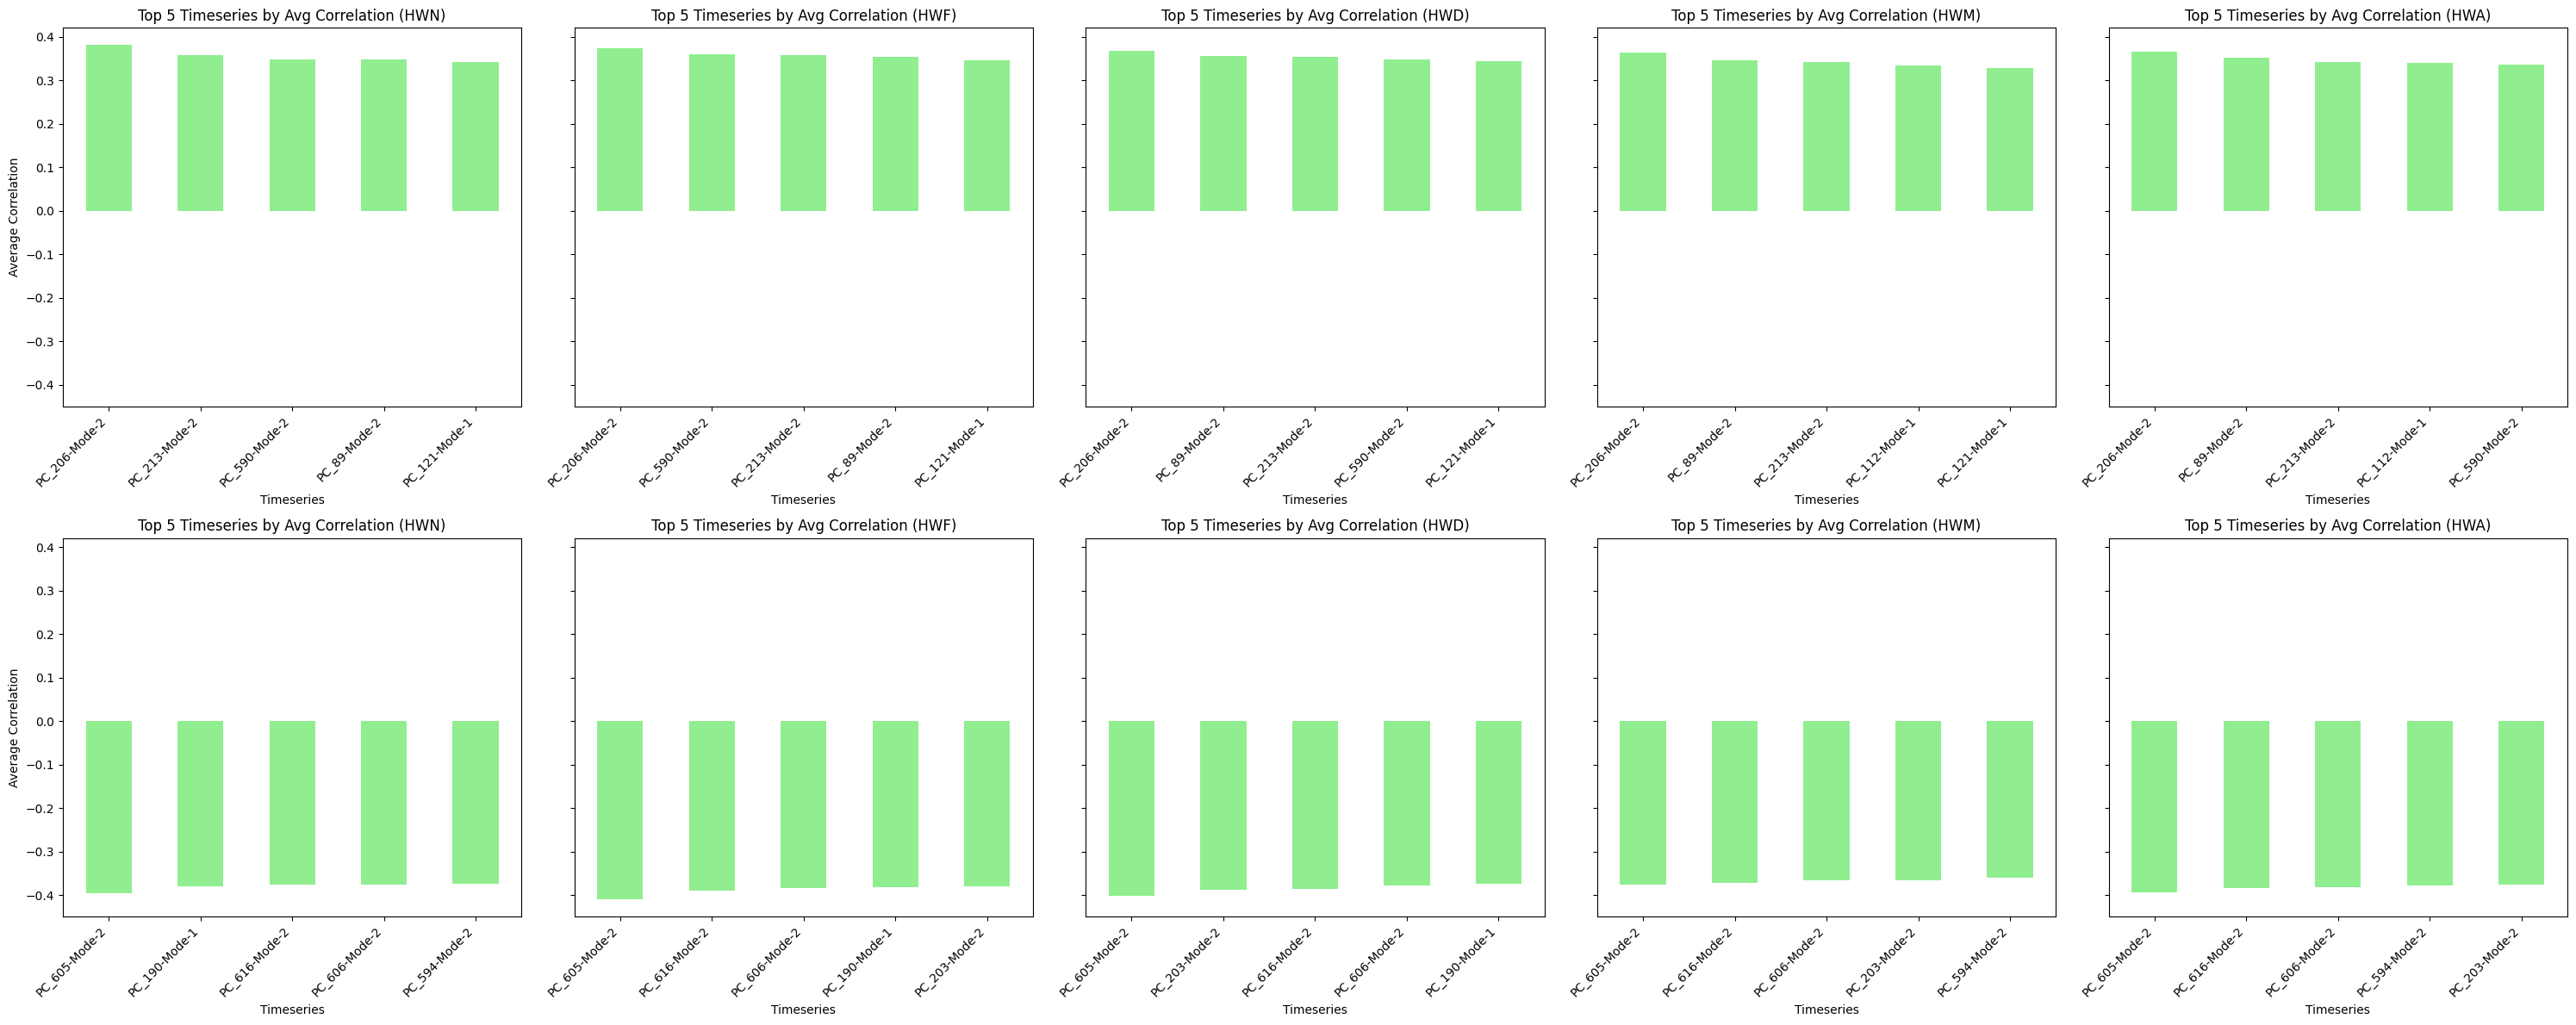

In [44]:
index_avg_correlation_top = {}
index_avg_correlation_low = {}


# Iterate over each index and compute average correlation
for index in indices_of_interest:
    # Filter the DataFrame for the current index
    index_df = any_correlations_df_cali[any_correlations_df_cali['Index'] == index]
    # Calculate the average correlation for each timeseries
    index_avg_correlation_top[index] = index_df.groupby('PC')['Correlation'].mean().sort_values(ascending=False)
    index_avg_correlation_low[index] = index_df.groupby('PC')['Correlation'].mean().sort_values(ascending=True)

# Get the top 20 timeseries by average correlation for each index
top_20_index_avg_correlation = {
    index: correlations.head(5) for index, correlations in index_avg_correlation_top.items()
}
low_20_index_avg_correlation = {
    index: correlations.head(5) for index, correlations in index_avg_correlation_low.items()
}

# Plot the top 20 timeseries by average correlation for each index
fig, axes = plt.subplots(2, 5, figsize=(30, 12), sharey=True)

for i, index in enumerate(indices_of_interest):
    ax = axes.flatten()[i]
    if index in top_20_index_avg_correlation:
        top_20_index_avg_correlation[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Avg Correlation ({index})')
        ax.set_xlabel('Timeseries')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Average Correlation')
    ax = axes.flatten()[i+5]
    if index in low_20_index_avg_correlation:
        low_20_index_avg_correlation[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Avg Correlation ({index})')
        ax.set_xlabel('Timeseries')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Average Correlation')


plt.tight_layout()
plt.show()

## Both simultaneously

In [45]:
all_correlations_df_chile.rename(columns={"Correlation": "Corr_Chile"}, inplace=True)
all_correlations_df_cali.rename(columns={"Correlation": "Corr_Cali"}, inplace=True)
both_correlations = all_correlations_df_chile.merge(all_correlations_df_cali, 'inner', on=["Season", "PC", "Index"])[["Season", "ID_x", "PC", "Index", "Corr_Chile", "Corr_Cali"]]
both_correlations["Mean_corr"] = (abs(both_correlations["Corr_Cali"]) + abs(both_correlations["Corr_Chile"]))/2
both_correlations

Season ID_x             PC Index  Corr_Chile  Corr_Cali  Mean_corr
0         1  189  PC_189-Mode-2   HWD    0.512500   0.509713   0.511106
1         1  189  PC_189-Mode-2   HWD    0.512500   0.597561   0.555030
2         1   68   PC_68-Mode-2   HWD   -0.511798  -0.500095   0.505946
3         1  533  PC_533-Mode-2   HWD   -0.566259  -0.528601   0.547430
4         2  217  PC_217-Mode-2   HWN    0.552136   0.543497   0.547817
..      ...  ...            ...   ...         ...        ...        ...
326      12  686  PC_686-Mode-2   HWN   -0.532206  -0.521606   0.526906
327      12  686  PC_686-Mode-2   HWF   -0.598283  -0.521033   0.559658
328      12  177  PC_177-Mode-3   HWN   -0.504252  -0.569829   0.537041
329      12  177  PC_177-Mode-3   HWF   -0.505910  -0.548297   0.527103
330      12  177  PC_177-Mode-3   HWD   -0.529063  -0.503562   0.516313

[331 rows x 7 columns]

In [46]:
top_both_corr = both_correlations.sort_values("Mean_corr", ascending=False).head(20)
top_both_corr

Season ID_x             PC Index  Corr_Chile  Corr_Cali  Mean_corr
112       7  357  PC_357-Mode-2   HWF    0.569724   0.750802   0.660263
114       7  357  PC_357-Mode-2   HWD    0.564339   0.738509   0.651424
321      12  683  PC_683-Mode-3   HWF    0.762364   0.536781   0.649572
113       7  357  PC_357-Mode-2   HWD    0.564339   0.728090   0.646214
111       7  357  PC_357-Mode-2   HWF    0.569724   0.721910   0.645817
109       7  357  PC_357-Mode-2   HWN    0.559668   0.720004   0.639836
323      12  683  PC_683-Mode-3   HWD    0.751837   0.523081   0.637459
110       7  357  PC_357-Mode-2   HWN    0.559668   0.713751   0.636710
93        7  348  PC_348-Mode-1   HWD    0.631219   0.629717   0.630468
89        7  348  PC_348-Mode-1   HWF    0.627678   0.631032   0.629355
85        7  348  PC_348-Mode-1   HWN    0.614284   0.630552   0.622418
90        7  348  PC_348-Mode-1   HWF    0.627678   0.595600   0.611639
252       8  154  PC_154-Mode-2   HWA    0.696186  -0.516702   0.606444
94        7  348  PC_348-Mode-1   HWD    0.631219   0.567007   0.599113
120       7  344  PC_344-Mode-1   HWF   -0.627760  -0.570395   0.599078
86        7  348  PC_348-Mode-1   HWN    0.614284   0.573868   0.594076
119       7  344  PC_344-Mode-1   HWF   -0.627760  -0.554038   0.590899
91        7  348  PC_348-Mode-1   HWD    0.551536   0.629717   0.590626
312       8  301  PC_301-Mode-1   HWF    0.617737  -0.562934   0.590335
227       8  149  PC_149-Mode-2   HWF    0.665128  -0.514677   0.589903

PC_357 is on Box [247.5, 290, -30, 0] with variables ['SST', 'SP', 'U10']


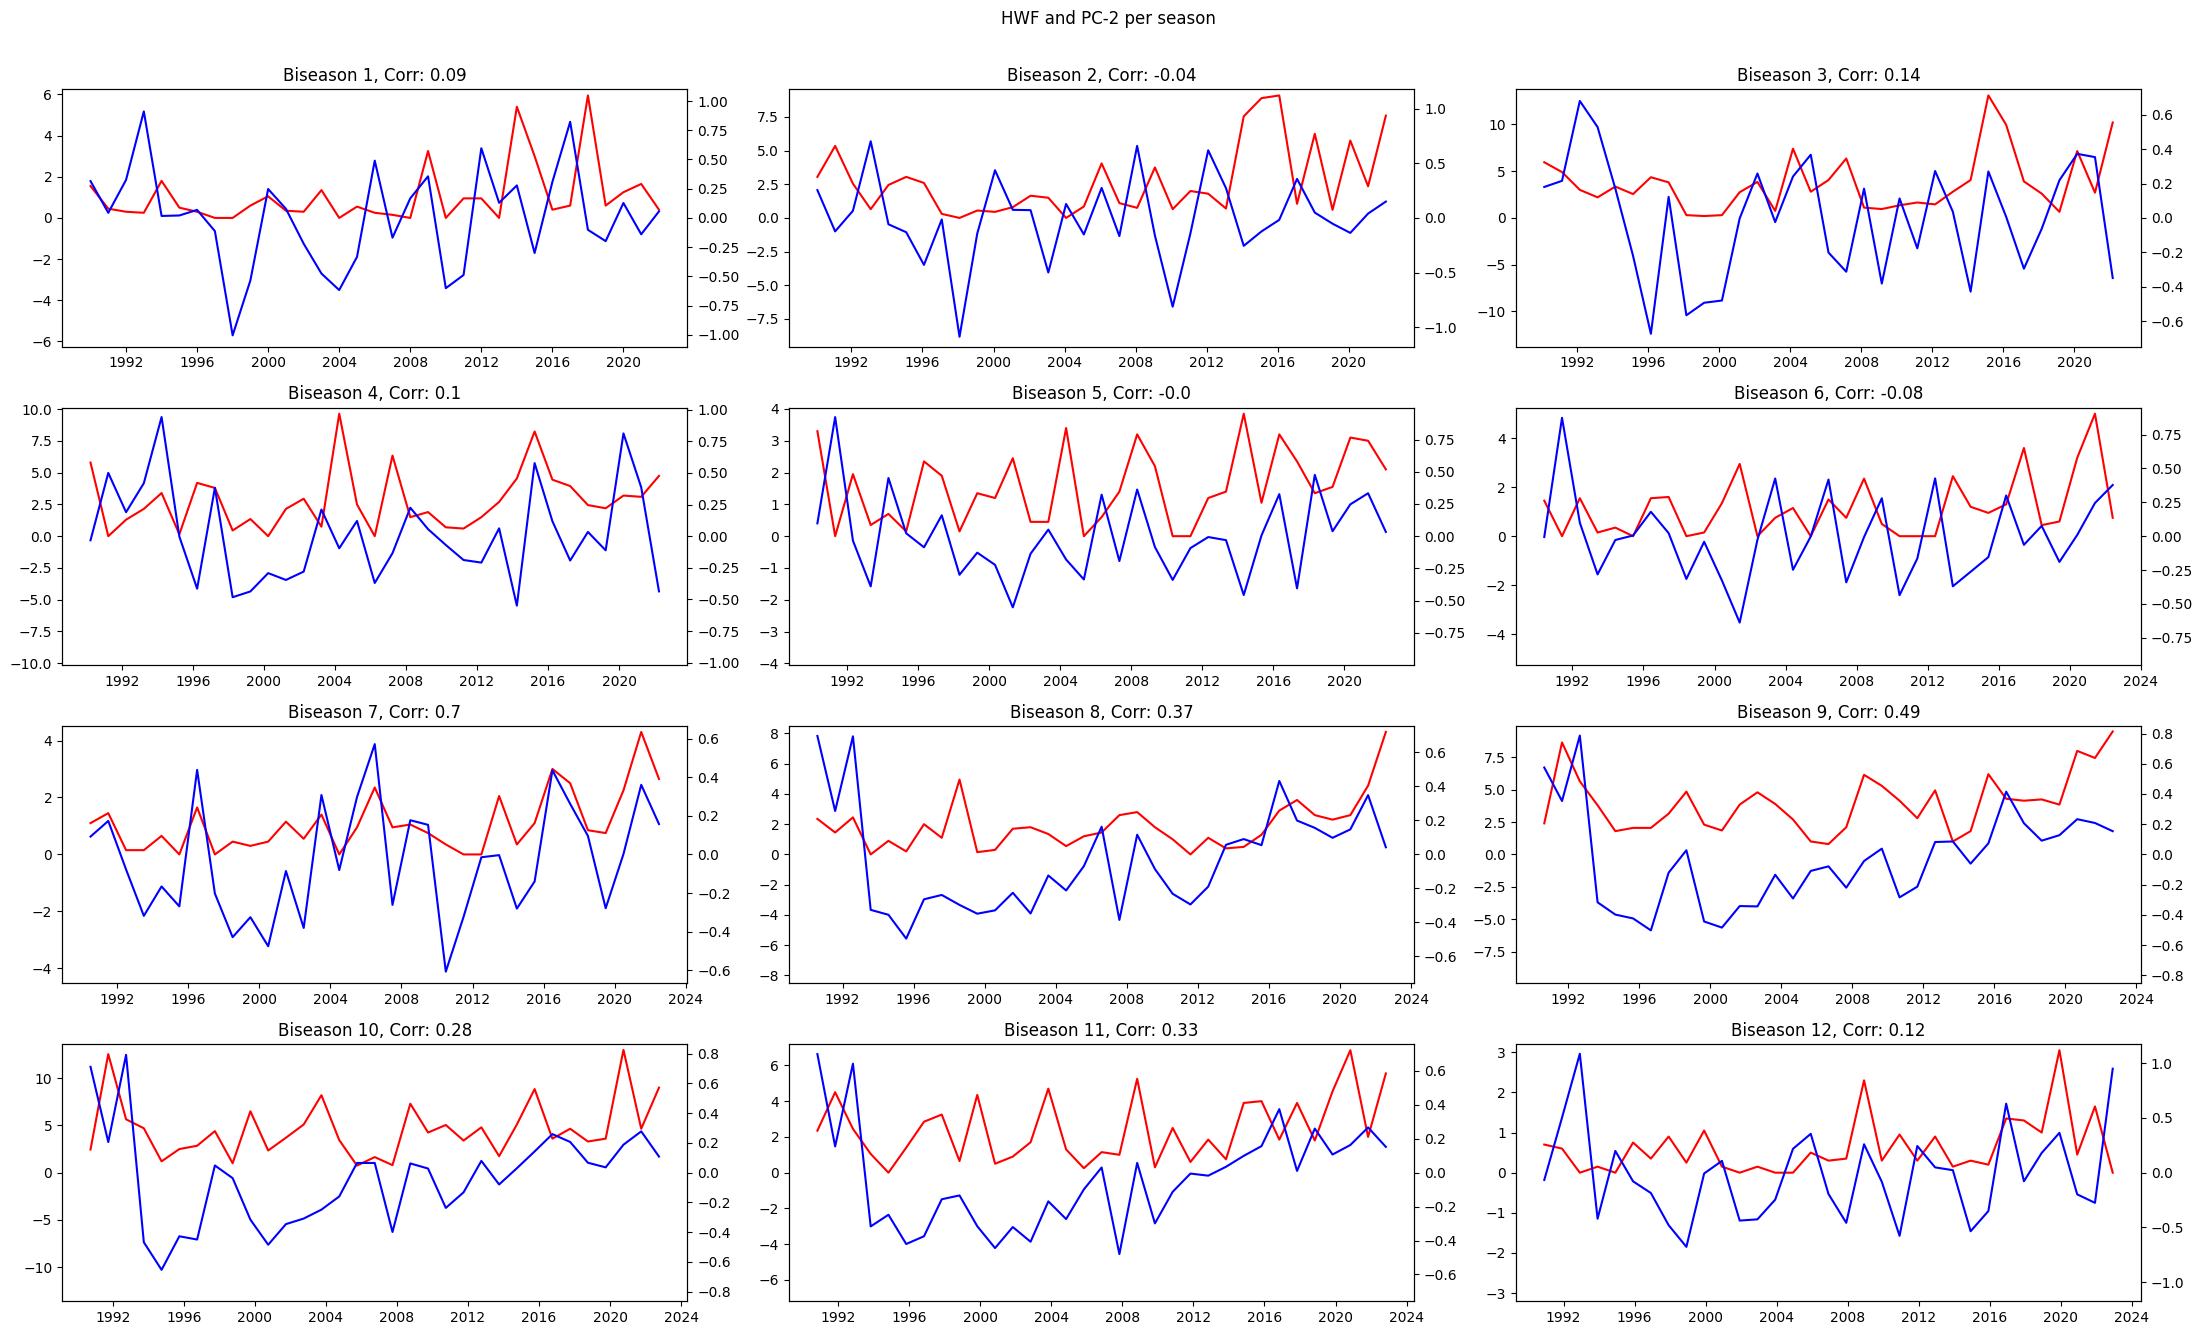

In [47]:
top1 = int(list(top_both_corr["ID_x"])[0])
mode_top1 = int(list(top_both_corr["PC"])[0][-1])
print(f"PC_{top1} is on Box {pcas[top1].box} with variables {list(pcas[top1].variables_dict.values())}")
plot_hw_index_by_season(hwis_cali, "HWF", pcas[top1], mode_top1, start=first_year)

## Select 20 Highest for Chile Model

In [49]:
top_corr_per_season_chile = {}
id_per_season_chile = {}
for i in range(1,13):
    month_corr = all_correlations_df_chile[all_correlations_df_chile["Season"]==i]
    top_corr = month_corr.reindex(
    month_corr["Corr_Chile"].abs().sort_values(ascending=False).index
    )
    top_corr_per_season_chile[i] = []
    id_per_season_chile[i] = []
    k = 0
    for pc in list(top_corr["PC"]):
        if len(top_corr_per_season_chile[i]) == 20:
            break
        elif pc not in top_corr_per_season_chile[i]:
            top_corr_per_season_chile[i].append(pc)

print({i:len(top_corr_per_season_chile[i]) for i in range(1,13)})

{1: 20, 2: 1, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 3, 10: 9, 11: 19, 12: 20}


In [50]:
save= True
if save:
    for i in range(1,13):
        hws_season = hwis_chile[hwis_chile.index.month == i][indices_of_interest + top_corr_per_season_chile[i]]
        hws_season.to_csv(f"HWs_chile_features_biseason_{i}.csv")

In [80]:
save_year= False
if save_year:
    pcs = []
    for i in range(1,13):
        pcs = pcs + top_corr_per_season_chile[i]
    
    hws_year = hwis_chile[indices_of_interest + pcs]
    hws_year.to_csv("HWs_chile_features_biseasonly_year.csv")

### Select best but removing low variance explaining ones.

In [57]:
top_corr_per_season_chile = {}
id_per_season_chile = {}

filtered_df_chile = all_correlations_df_chile[all_correlations_df_chile["Variance"] >= 0.15]
for i in range(1,13):
    month_corr = filtered_df_chile[filtered_df_chile["Season"]==i]
    top_corr = month_corr.reindex(
    month_corr["Corr_Chile"].abs().sort_values(ascending=False).index
    )
    top_corr_per_season_chile[i] = []
    id_per_season_chile[i] = []
    k = 0
    for pc in list(top_corr["PC"]):
        if len(top_corr_per_season_chile[i]) == 20:
            break
        elif pc not in top_corr_per_season_chile[i]:
            top_corr_per_season_chile[i].append(pc)

print("Features per month", {i:len(top_corr_per_season_chile[i]) for i in range(1,13)})

save_season= True
if save_season:
    for i in range(1,13):
        hws_season = hwis_chile[hwis_chile.index.month == i][indices_of_interest + top_corr_per_season_chile[i]]
        hws_season.to_csv(f"HWs_chile_features_biseason_removing_{i}.csv")
save_year= True
if save_year:
    pcs = []
    for i in range(1,13):
        pcs = pcs + top_corr_per_season_chile[i]
    
    hws_year = hwis_chile[indices_of_interest + pcs]
    hws_year.to_csv("HWs_chile_features_biseasonly_removing_year.csv")

Features per month {1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 9, 11: 20, 12: 20}


## Save 20 California

In [83]:
top_corr_per_season_cali = {}
id_per_season_cali = {}
for i in range(1,13):
    month_corr = all_correlations_df_cali[all_correlations_df_cali["Season"]==i]
    top_corr = month_corr.reindex(
    month_corr["Corr_Cali"].abs().sort_values(ascending=False).index
    )
    top_corr_per_season_cali[i] = []
    id_per_season_cali[i] = []
    k = 0
    for pc in list(top_corr["PC"]):
        if len(top_corr_per_season_cali[i]) == 20:
            break
        elif pc not in top_corr_per_season_chile[i]:
            top_corr_per_season_cali[i].append(pc)

print({i:len(top_corr_per_season_cali[i]) for i in range(1,13)})

{1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


In [85]:
save= False
if save:
    for i in range(1,13):
        hws_season = hwis_cali[hwis_cali.index.month == i][indices_of_interest + top_corr_per_season_cali[i]]
        hws_season.to_csv(f"HWs_cali_features_biseason_{i}.csv")

In [86]:
save_year= False
if save_year:
    pcs = []
    for i in range(1,13):
        pcs = pcs + top_corr_per_season_cali[i]
    
    hws_year = hwis_cali[indices_of_interest + pcs]
    hws_year.to_csv("HWs_cali_features_biseasonly_year.csv")

### Select best but removing low variance explaining ones.

In [ ]:
top_corr_per_season_cali = {}
id_per_season_chile = {}

filtered_df_chile = all_correlations_df_chile[all_correlations_df_chile["Variance"] >= 0.15]
for i in range(1,13):
    month_corr = filtered_df_chile[filtered_df_chile["Season"]==i]
    top_corr = month_corr.reindex(
    month_corr["Corr_Chile"].abs().sort_values(ascending=False).index
    )
    top_corr_per_season_cali[i] = []
    id_per_season_chile[i] = []
    k = 0
    for pc in list(top_corr["PC"]):
        if len(top_corr_per_season_cali[i]) == 20:
            break
        elif pc not in top_corr_per_season_cali[i]:
            top_corr_per_season_cali[i].append(pc)

print("Features per month", {i:len(top_corr_per_season_cali[i]) for i in range(1,13)})

save_season= True
if save_season:
    for i in range(1,13):
        hws_season = hwis_cali[hwis_cali.index.month == i][indices_of_interest + top_corr_per_season_cali[i]]
        hws_season.to_csv(f"HWs_cali_features_biseason_removing_{i}.csv")
save_year= True
if save_year:
    pcs = []
    for i in range(1,13):
        pcs = pcs + top_corr_per_season_cali[i]
    
    hws_year = hwis_cali[indices_of_interest + pcs]
    hws_year.to_csv("HWs_cali_features_biseasonly_removing_year.csv")

Features per month {1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 9, 11: 20, 12: 20}
